# Basics of Maching Learning, Fall 2024
## Final Project, Phase 2
Contributors:
- Paria Parsehvarz - 810101393
- Majid Faridfar - 810199569
- Fateme Mohammadi - 810199489

# Part 0: Getting Ready

## Installs

In [1]:
!pip install librosa

In [ ]:
!pip install kneed

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = "/content/drive/MyDrive/Machine-Learning/Final-Project/HW1_M"

Mounted at /content/drive


# Part 1: Preprocessing data

## Select part of data as our dataset

### 1. Get list of all audio files.

In [ ]:
import os
import random

all_files = [f for f in os.listdir(folder_path) if f.endswith(('.wav', '.mp3', '.flac'))]

### 2. Separate male and female files

In [ ]:
male_files = [f for f in all_files if "_male" in f]
female_files = [f for f in all_files if "_female" in f]

### 3. As we should have equal number of male and female audio files in train and test, we should find out which one is less

In [ ]:
min_gender_count = min(len(male_files), len(female_files))

### 4. Get 25% for test and 75% for train from the smaller gender

In [ ]:
test_size = int(0.25 * min_gender_count)
train_size = min_gender_count - test_size

### 5. Shuffle files for randomness

In [ ]:
random.shuffle(male_files)
random.shuffle(female_files)

### 6. Select test and train files for the smaller gender

In [ ]:
if len(male_files) == min_gender_count:
    test_male = male_files[:test_size]
    train_male = male_files[test_size:train_size + test_size]

    test_female = female_files[:test_size]
    train_female = female_files[test_size:train_size + test_size]
else:
    test_female = female_files[:test_size]
    train_female = female_files[test_size:train_size + test_size]

    test_male = male_files[:test_size]
    train_male = male_files[test_size:train_size + test_size]

In [ ]:
print(f"Training Set, Male: {len(train_male)} files")
print(f"Training Set, Female: {len(train_female)} files")
print("\n")
print(f"Testing Set, Male: {len(test_male)} files")
print(f"Testing Set, Female: {len(test_female)} files")

Training Set, Male: 143 files
Training Set, Female: 143 files


Testing Set, Male: 47 files
Testing Set, Female: 47 files


### 7. Combine lists

In [ ]:
train_files = train_male + train_female
test_files = test_male + test_female

In [ ]:
print(f"Total Male Files: {len(male_files)}")
print(f"Total Female Files: {len(female_files)}")
print("\n")
print(f"Training Set: {len(train_files)} files")
print(f"Testing Set: {len(test_files)} files")

Total Male Files: 549
Total Female Files: 190


Training Set: 286 files
Testing Set: 94 files


### 8. Save test and train files selected in a txt file

In [ ]:
def save_file_list(file_list, filename):
    with open(filename, 'w') as f:
        for file in file_list:
            f.write(file + '\n')

drive_data_splits_dir = "/content/drive/MyDrive/Machine-Learning/Final-Project/data_splits"
os.makedirs(drive_data_splits_dir, exist_ok=True)

train_file_path = os.path.join(drive_data_splits_dir, "train_files.txt")
test_file_path = os.path.join(drive_data_splits_dir, "test_files.txt")

save_file_list(train_files, train_file_path)
save_file_list(test_files, test_file_path)

## Extract Features from Audio Signals

To analyze the properties of the audio signals in train_files, we can check various aspects such as:

* Duration – Total length of the audio file in seconds.
* Sampling Rate (sr) – The number of audio samples per second (e.g., 44,100 Hz).
* Mean Amplitude – The average amplitude of the signal (indicates loudness).
* Max Amplitude – The highest peak in the audio waveform (loudest moment).
* Min Amplitude – The lowest dip in the waveform (softest moment).
* Spectral Centroid – Represents the "center of mass" of the spectrum (perceived brightness of sound).
* Spectral Bandwidth – Measures how spread out frequencies are (variation in pitch).
* Zero-Crossing Rate – Counts how often the signal crosses zero (higher for percussive sounds).
* Energy – The sum of squared amplitudes, representing overall power of the sound.
* Log Mel Spectrogram – A representation of frequencies over time, scaled to human hearing.
* MFCC (Mel-Frequency Cepstral Coefficients) – A set of coefficients capturing the timbre and shape of sound, often used in speech and music analysis.

In [ ]:
import librosa
import numpy as np
import os
from tabulate import tabulate
from termcolor import colored

def analyze_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)

    mean_amplitude = np.mean(y)
    max_amplitude = np.max(y)
    min_amplitude = np.min(y)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
    energy = np.mean(y**2)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spec = np.mean(librosa.power_to_db(mel_spec))

    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)

    filename = colored(os.path.basename(file_path), 'cyan', attrs=['bold'])

    return [
        filename,
        colored(f"{duration:.2f} s", "magenta"),
        colored(sr, "yellow"),
        colored(f"{mean_amplitude:.5f}", "blue"),
        colored(f"{max_amplitude:.5f}", "green"),
        colored(f"{min_amplitude:.5f}", "red"),
        colored(f"{spectral_centroid:.2f} Hz", "cyan"),
        colored(f"{spectral_bandwidth:.2f} Hz", "yellow"),
        colored(f"{zero_crossing_rate:.5f}", "magenta"),
        colored(f"{energy:.5f}", "green"),
        colored(f"{log_mel_spec:.2f} dB", "blue")
    ] + [colored(f"{coeff:.2f}", "cyan") for coeff in mfcc]

In [ ]:
headers = [
    colored("Filename", "white", "on_blue"),
    colored("Duration", "white", "on_black"),
    colored("Sampling Rate", "black", "on_yellow"),
    colored("Mean Amp", "white", "on_magenta"),
    colored("Max Amp", "white", "on_green"),
    colored("Min Amp", "white", "on_red"),
    colored("Spectral Centroid", "white", "on_cyan"),
    colored("Spectral Bandwidth", "black", "on_yellow"),
    colored("Zero Crossing Rate", "white", "on_magenta"),
    colored("Energy", "white", "on_green"),
    colored("Log Mel Spec", "black", "on_blue")
] + [colored(f"MFCC-{i+1}", "white", "on_black") for i in range(13)]

train_files_subset = train_files[:10]
train_properties = [analyze_audio(os.path.join(folder_path, file)) for file in train_files_subset]

print(tabulate(train_properties, headers=headers, tablefmt="fancy_grid", stralign="center"))

## Visualizing Audio Signals

### 1. Plot waveform

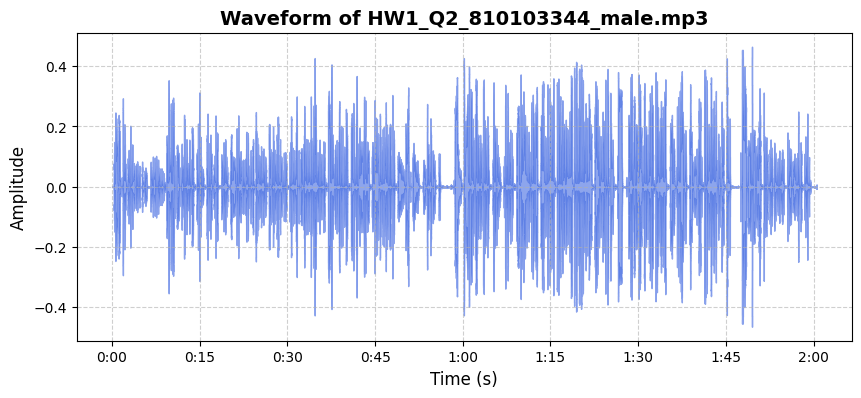

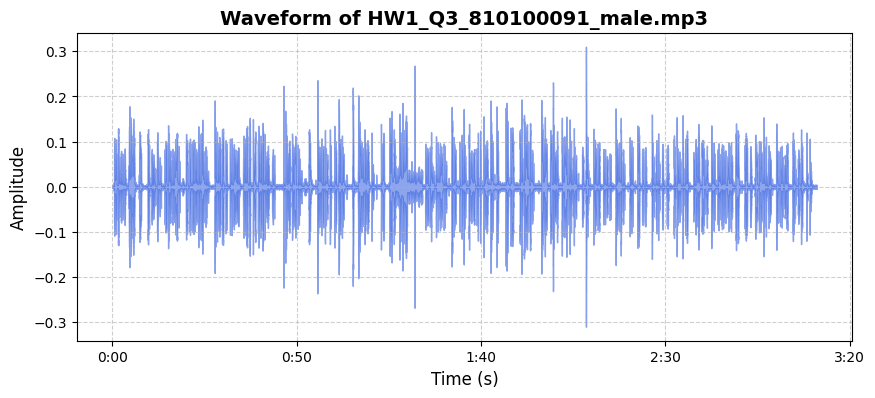

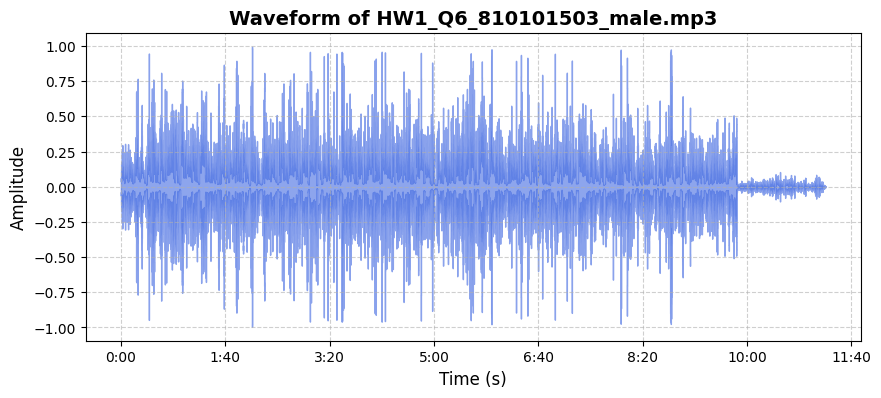

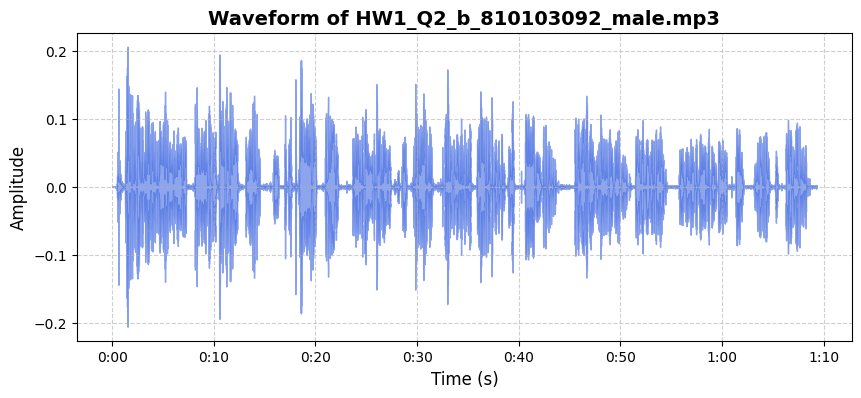

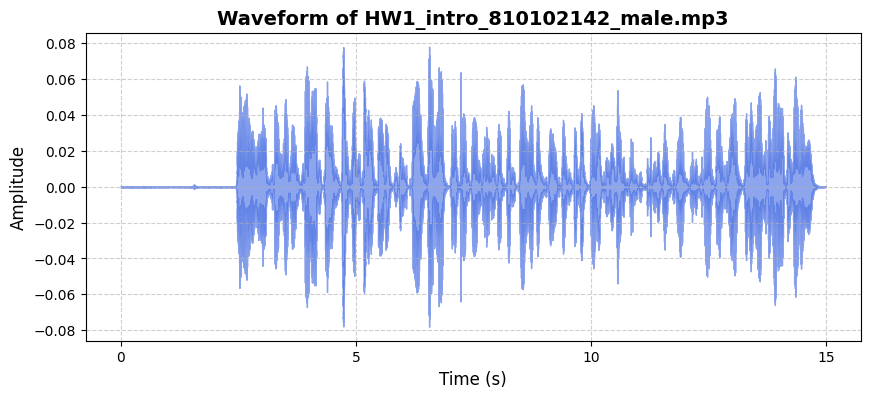

In [ ]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt

def plot(file_path):
    y, sr = librosa.load(file_path, sr=None)
    filename = os.path.basename(file_path)

    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.6, color='royalblue')
    plt.title(f"Waveform of {filename}", fontsize=14, fontweight='bold')
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

train_files_subset = train_files[:5]
train_properties = [plot(os.path.join(folder_path, file)) for file in train_files_subset]

### 2. Plot Spectrogram

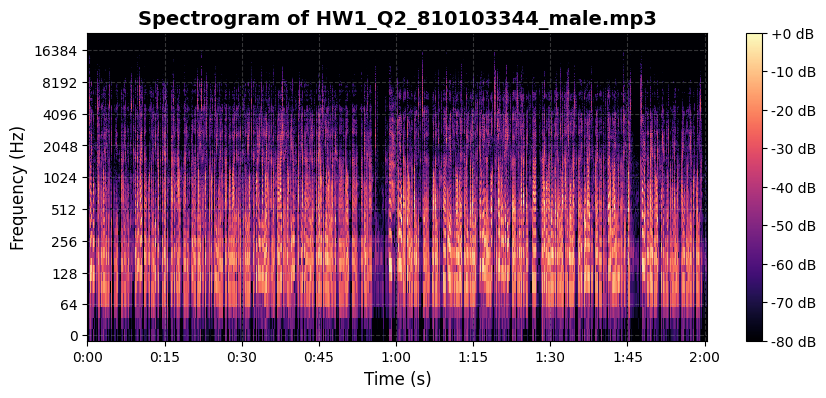

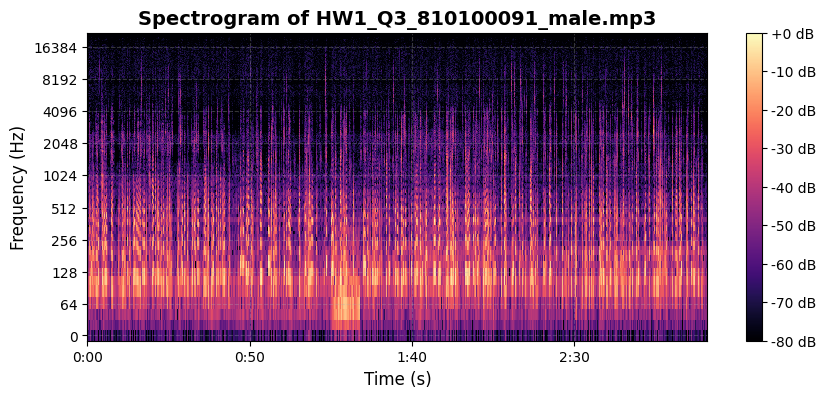

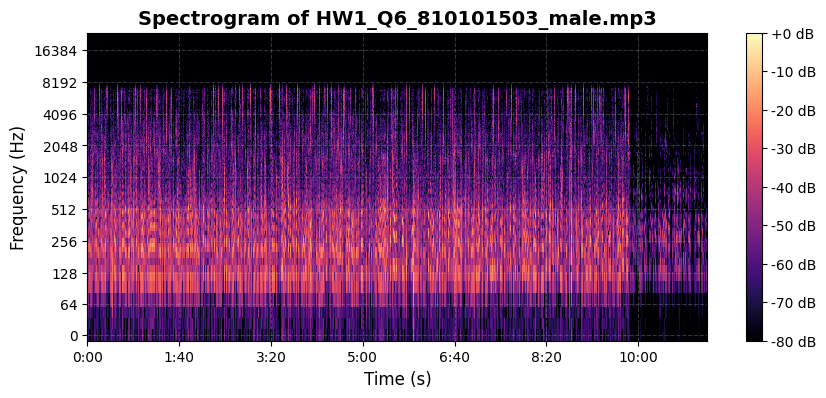

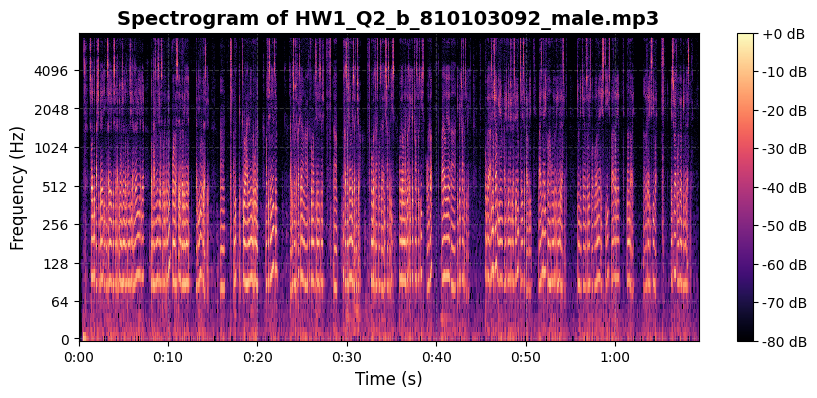

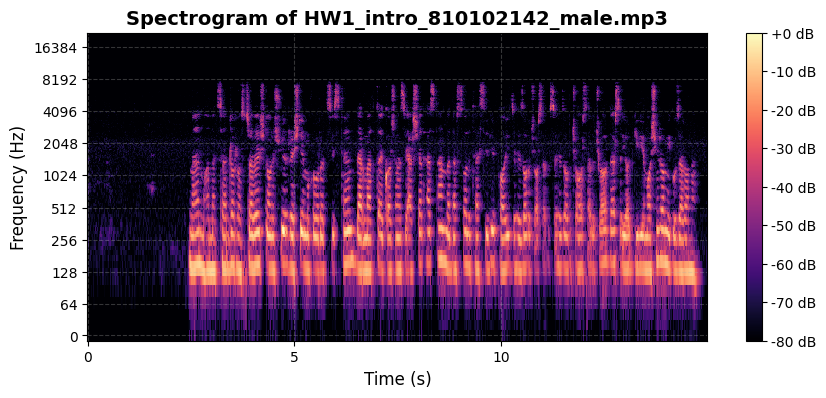

In [ ]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from tabulate import tabulate

def plot_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)

    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram of {os.path.basename(file_path)}", fontsize=14, fontweight='bold')
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Frequency (Hz)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()

train_files_subset = train_files[:5]

for file in train_files_subset:
    plot_spectrogram(os.path.join(folder_path, file))

## Removing Noise

* The waveform appears smooth with no abrupt changes, it often indicates constant noise (e.g., background hum).

* Additionally, We can see broad and consistent frequency bands across the spectrogram, it could indicate stationary noise. Low-frequency or high-frequency consistency often suggests background hum or electrical noise.

* Analyzing properties of first 5 files shows a relatively low mean amplitude and a moderate spectral centroid. The noise here could likely be stationary noise (e.g., fan hum or slight hum from mic).

As we have smooth, consistent patterns, we should use spectral gating or low-pass filters for removing background hum.

### Function to perform spectral gating on audio files and save to a new folder

In [ ]:
!pip install noisereduce

In [ ]:
import os
import librosa
import noisereduce as nr
import soundfile as sf

def remove_noise_with_spectral_gating(folder_path, train_files, new_folder_path):
    os.makedirs(new_folder_path, exist_ok=True)
    without_noise_files = []

    for file in train_files:
        file_path = os.path.join(folder_path, file)

        signal, sr = librosa.load(file_path, sr=None)

        reduced_noise_signal = nr.reduce_noise(y=signal, sr=sr, prop_decrease=1.0)

        cleaned_file_path = os.path.join(new_folder_path, f"withoutNoise_{file}")
        sf.write(cleaned_file_path, reduced_noise_signal, sr)

        without_noise_files.append(cleaned_file_path)

    return without_noise_files

### Remove noise from all training files and save in the new folder

In [ ]:
new_folder_path = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/noise_removed"
without_noise_train_files = remove_noise_with_spectral_gating(folder_path, train_files, new_folder_path)

### Now we should remove noise from test files, too

In [ ]:
new_folder_path = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/test_data/noise_removed"
without_noise_test_files = remove_noise_with_spectral_gating(folder_path, test_files, new_folder_path)

## Resampling

### 1. First, we should check if train files has different sampling rate or not:

In [ ]:
train_folder_path = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/noise_removed"
for file in without_noise_train_files[0:9]:
    y, sr = librosa.load(os.path.join(train_folder_path, file), sr=None)
    print(f"{file}: {sr} Hz")


/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/noise_removed/withoutNoise_HW1_Q5_810103019_male.mp3: 48000 Hz
/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/noise_removed/withoutNoise_HW1_Q6_810103146_male.mp3: 44100 Hz
/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/noise_removed/withoutNoise_HW1_Q4_810199417_male.mp3: 48000 Hz
/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/noise_removed/withoutNoise_HW1_Q6_810199423_male.mp3: 44100 Hz
/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/noise_removed/withoutNoise_HW1_Q3_810103146_male.mp3: 44100 Hz
/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/noise_removed/withoutNoise_HW1_Q2_610399205_male.mp3: 44100 Hz
/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/noise_removed/withoutNoise_HW1_Q4_810102032_male.mp3: 44100 Hz
/content/driv

### 2. As, we see, there are different sampling rate, so we should resample them.

In [ ]:
import librosa
import soundfile as sf
import os

TARGET_SR = 44100

def resample_audio(folder_path, new_folder_path):
    os.makedirs(new_folder_path, exist_ok=True)

    resampled_files = []

    audio_extensions = ('.wav', '.mp3', '.flac')
    all_files = [f for f in os.listdir(folder_path) if f.endswith(audio_extensions)]

    for file in all_files:
        file_path = os.path.join(folder_path, file)
        new_file_path = os.path.join(new_folder_path, f"resampled_{file}")

        y, sr = librosa.load(file_path, sr=None)

        if sr != TARGET_SR:
            y = librosa.resample(y, orig_sr=sr, target_sr=TARGET_SR)

        sf.write(new_file_path, y, TARGET_SR)

        resampled_files.append(new_file_path)

    return resampled_files


In [ ]:
without_noise_path = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/noise_removed"
resampled_folder = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/resampled"
resampled_train_files = resample_audio(without_noise_path, resampled_folder)

#### And, resample test files too:

In [ ]:
without_noise_path = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/test_data/noise_removed"
resampled_folder = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/test_data/resampled"
resampled_test_files = resample_audio(without_noise_path, resampled_folder)

## Normalizing

### 1. We will use standardize method here:

In [ ]:
def standardize(y):
  return (y - np.mean(y)) / np.std(y)

In [ ]:
import librosa
import numpy as np
import os
import soundfile as sf

def normalize_audio(folder_path, new_folder_path):
    os.makedirs(new_folder_path, exist_ok=True)

    normalized_files = []

    audio_extensions = ('.wav', '.mp3', '.flac')
    all_files = [f for f in os.listdir(folder_path) if f.endswith(audio_extensions)]

    for file in all_files:
        file_path = os.path.join(folder_path, file)
        new_file_path = os.path.join(new_folder_path, f"normalized_{file}")

        y, sr = librosa.load(file_path, sr=None)

        y = standardize(y)

        sf.write(new_file_path, y, sr)

        normalized_files.append(new_file_path)

    return normalized_files

### 2. First, we standardize train files:

In [ ]:
resampled_folder = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/resampled"
normalized_path = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/normalized"
normalized_train_files = normalize_audio(resampled_folder, normalized_path)

### 3. And then test files:

In [ ]:
resampled_folder = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/test_data/resampled"
normalized_path = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/test_data/normalized"
normalized_test_files = normalize_audio(resampled_folder, normalized_path)

## Framing

* Frame size is typically a power of 2 (e.g., 256, 512, 1024, 2048) for efficient FFT computation, use 256 or 512 samples is good for speech processing.

* Hop Length (Stride) defines the overlap between consecutive frames, it controls time resolution and smoothness of feature extraction. We usually set as a fraction of the frame size:
 50% overlap (hop = frame_size / 2) → Standard for many applications.
 As we had lack of space, i used hop-length = 512

In [ ]:
import librosa
import numpy as np
import os

def split_and_save_frames(folder_path, new_folder_path, frame_size=512, hop_length=512):
    os.makedirs(new_folder_path, exist_ok=True)

    audio_extensions = ('.wav', '.mp3', '.flac')
    all_files = [f for f in os.listdir(folder_path) if f.endswith(audio_extensions)]

    for file in all_files:
        file_path = os.path.join(folder_path, file)
        y, sr = librosa.load(file_path, sr=None)

        frames = librosa.util.frame(y, frame_length=frame_size, hop_length=hop_length).astype(np.float16)

        npy_filename = os.path.splitext(file)[0] + "_frames.npy"
        np.savez_compressed(os.path.join(new_folder_path, npy_filename.replace(".npy", ".npz")), frames)

### 1. First, we frame train files:

In [ ]:
normalized_path = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/normalized"
framed_folder = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/framed"
split_and_save_frames(normalized_path, framed_folder)

### 2. And then, test files:

In [ ]:
normalized_path = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/test_data/normalized"
framed_folder = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/test_data/framed"
split_and_save_frames(normalized_path, framed_folder)

# Part 2: Classification

## Imports

In [3]:
import os
import numpy as np
import pandas as pd
import re  # For regex pattern matching

import librosa

from tabulate import tabulate
from termcolor import colored

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import label_binarize

import random

## Utils

In this section, we define a few functions that are useful in the rest of the project.

Note: We used comments to better explain some parts of the functions.

The following function is used to extract `Student ID` and `Gender` of each student from the name of their sent files. We used `regex` to achieve this goal and used correct expressions for reading desired information.

In [4]:
def extract_labels(file_name):
    """Extracts student ID (9-digit number) and gender from the file name using regex."""

    # Find student ID (a 9-digit number)
    student_id_match = re.search(r"\d{9}", file_name)
    student_id = student_id_match.group() if student_id_match else "Unknown"

    # Find gender (either 'male' or 'female')
    gender_match = re.search(r"(male|female)", file_name, re.IGNORECASE)
    gender = gender_match.group().lower() if gender_match else "Unknown"

    return student_id, gender

The following function is for loading and unzipping the files that underwent all the preprocessing steps we cosidered in the previous section (they were stored in a `Google Drive` folder). This function, in addition to loading and unzipping files, extracts their specified gender and student ID. The output of this function is a list of tuples including a list student's recorded voice frames, their ID and their gender.

Here, we also merge each `100` (this number can be changed as it is the function's argument) frames to have longer frames but less frames overall. This decision was made because of the poor performance of model when trained on data with 512-sized frames (which was specified in the preprocessing step). As in the preprocessing section, `hop length` was set to 512, the frames don't have overlap and they can be easily concatinated.

In [5]:
def load_and_unzip_frames(folder_path, merge_factor=100):
    labeled_frames_list = []  # List to store (frames, student_id, gender)
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".npz")]

    print(f"Total files found: {len(all_files)}")

    for file in all_files:
        file_path = os.path.join(folder_path, file)

        # Extract labels from file name
        student_id, gender = extract_labels(file)

        with np.load(file_path) as data:
            frames = data["arr_0"]  # Extract the stored numpy array

            # Merging frames
            original_frame_size, num_frames = frames.shape  # (frame_size, num_frames)

            # New frame size and number of frames
            new_num_frames = num_frames // merge_factor
            new_frame_size = original_frame_size * merge_factor

            if num_frames % merge_factor != 0:
                frames = frames[:, :new_num_frames * merge_factor]  # Trim excess frames

            # Reshape to increase frame size while reducing frame count
            merged_frames = frames.reshape(original_frame_size, merge_factor, new_num_frames)
            merged_frames = merged_frames.transpose(1, 0, 2).reshape(new_frame_size, new_num_frames)

            labeled_frames_list.append((merged_frames, student_id, gender))  # Store frames with labels

    return labeled_frames_list

The following function is used for extracting features of each individual frame. As in the preprocessing, we set all the `sampling rate` to an equal and specific number, this function just requires the list of samples over time and the sampling rate to calculate features. The way it extract each feature is just like we explained in the previous section. We just changed the format of its retuen value. As you can see, it just outputs a simple list containing the amount of each features in `string` format.

In [6]:
def analyze_audio_from_frames(y, sr, index):
    """Extracts features from an audio waveform instead of a file path which was implemented in part one."""
    duration = librosa.get_duration(y=y, sr=sr)

    mean_amplitude = np.mean(y)
    max_amplitude = np.max(y)
    min_amplitude = np.min(y)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y))
    energy = np.mean(y**2)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_mel_spec = np.mean(librosa.power_to_db(mel_spec))

    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)

    filename = f"Frame {index}"

    return [
        filename,
        f"{duration:.2f} s",
        sr,
        f"{mean_amplitude:.5f}",
        f"{max_amplitude:.5f}",
        f"{min_amplitude:.5f}",
        f"{spectral_centroid:.2f} Hz",
        f"{spectral_bandwidth:.2f} Hz",
        f"{zero_crossing_rate:.5f}",
        f"{energy:.5f}",
        f"{log_mel_spec:.2f} dB",
    ] + [f"{coeff:.2f}" for coeff in mfcc]

The next function iterates on all data entries, which are tuples containing student's samples, ID and gender. Then, it randomly selects `num_samples` samples for each student, due to the memory problem we faced in `Google Colab`. For each student and each of their frames it also extracts features and put them in `data_records`. In other words, this function looks at the data in the point of view of frames, instead of the way they were considered in `data_frames`, which was in the point of view of student. The output of this function is a `data frame`, each row of which specifies the features of each frame (in addition to the student ID and gender of their creator).

In [7]:
def extract_features_from_frames(data_frames, num_samples=5, sr=44100):
    data_records = []

    for frames, student_id, gender in data_frames:  # Iterate over each student's data
        num_frames = frames.shape[1]  # Total frames for this student
        num_samples = min(num_samples, num_frames)  # Ensure we don't sample more than available

        # Randomly select 10 unique frame indices
        selected_indices = np.random.choice(num_frames, num_samples, replace=False)

        for frame_index in selected_indices:  # Iterate over selected random frames
            single_frame = frames[:, frame_index]  # Extract one frame (512 samples)

            # Extract features using the function
            features = analyze_audio_from_frames(single_frame, sr, frame_index)

            # Convert colored output to plain text for DataFrame storage
            features = [str(f) for f in features]

            # Append student info and features to the list
            data_records.append([student_id, gender] + features)

    # Define column headers
    headers = ["Student ID", "Gender", "Frame ID", "Duration", "Sampling Rate", "Mean Amp",
              "Max Amp", "Min Amp", "Spectral Centroid", "Spectral Bandwidth", "Zero Crossing Rate",
              "Energy", "Log Mel Spec"] + [f"MFCC-{i+1}" for i in range(13)]

    # Convert the list into a Pandas DataFrame
    df = pd.DataFrame(data_records, columns=headers)

    return df

## Load Data

In this section, we load the data which was stored after doing preprocess in the previous section. We stored train and tests data separately, so we need to load and unzip them in the similar way. We use `load_and_unzip_frames` which we implemented and can be found in utils section. We also print some information after data is loaded to get more familiar with it. There is also an additional section which we considered in the train section and you can take a look at it.

### Train

In [11]:
train_framed_folder = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/train_data/framed"

train_frames = load_and_unzip_frames(train_framed_folder)

Total files found: 286


In [12]:
for i, (frames, student_id, gender) in enumerate(train_frames[:5]):  # Show first 5 examples
    print(f"File {i+1}: Frames Shape={frames.shape}, Student ID={student_id}, Gender={gender}")

File 1: Frames Shape=(51200, 103), Student ID=810103344, Gender=male
File 2: Frames Shape=(51200, 164), Student ID=810100091, Gender=male
File 3: Frames Shape=(51200, 581), Student ID=810101503, Gender=male
File 4: Frames Shape=(51200, 59), Student ID=810103092, Gender=male
File 5: Frames Shape=(51200, 12), Student ID=810102142, Gender=male


#### Merging All Frames for Each Student (Useful for Closed-Set Authentication)

In the preprocessing section, when we splitted our data into train and test parts, we did it regarding `Gender` feature (to have balanced data in each part). But for closed-set authentication task, we should do this splitting step regarding `Student ID` feature. A crucial thing here is to merge all frames assigned to one student. In this way data is more concentrated, and for each student we will have more smples if there is.

First, let's see how many unique student IDs we have.

In [15]:
student_ids = [student_id for _, student_id, _ in train_frames]
duplicates = set(student_ids)

if duplicates:
    print("Number of duplicate Student IDs found:", len(set(student_ids)))
else:
    print("No duplicate Student IDs found.")

Number of duplicate Student IDs found: 95


As you can see, a lot of data entries are duplicate, because among 286 data entries, student IDs of only 95 of them are different in terms of student ID. So, we can merge recorded frames of each stundet together. Due to the memory limitation we have in `Google Colab`, we do it inplace, meaning that in an iterative way, we find distinct student IDs and take all their frames together while removing the previous containers of those frames.

In [16]:
student_index_map = {}  # Maps student_id to index in train_frames
i = 0

while i < len(train_frames):
    frames, student_id, gender = train_frames[i]

    if student_id in student_index_map:
        # Student ID already exists, concatenate to first occurrence
        first_index = student_index_map[student_id]
        train_frames[first_index] = (
            np.concatenate((train_frames[first_index][0], frames), axis=1),  # Merge frames
            student_id,
            gender
        )

        # Remove the current duplicate entry
        del train_frames[i]
    else:
        # Store the first occurrence of student_id
        student_index_map[student_id] = i
        i += 1  # Move to next index only when no deletion occurs

### Test

In [ ]:
test_frames_folder = "/content/drive/MyDrive/Machine-Learning/Final-Project/cleaned_data/test_data/framed"

test_frames = load_and_unzip_frames(test_frames_folder)

Total files found: 94


In [ ]:
for i, (frames, student_id, gender) in enumerate(test_frames[:5]):  # Show first 5 examples
    print(f"File {i+1}: Frames Shape={frames.shape}, Student ID={student_id}, Gender={gender}")

File 1: Frames Shape=(51200, 369), Student ID=810103317, Gender=male
File 2: Frames Shape=(51200, 656), Student ID=810199417, Gender=male
File 3: Frames Shape=(51200, 49), Student ID=810199459, Gender=male
File 4: Frames Shape=(51200, 784), Student ID=810199569, Gender=male
File 5: Frames Shape=(51200, 486), Student ID=810600072, Gender=male


## Part 2.1: Gender Classification

### Feature Extraction

#### Train

First, using the function defined for feature extraction, we extracted features from train frames and save them in a dataframe.

In [ ]:
train_df = extract_features_from_frames(train_frames)

Let's look at it:

In [ ]:
train_df

Student ID  Gender   Frame ID Duration Sampling Rate  Mean Amp   Max Amp  \
0     810103344    male   Frame 29   1.16 s         44100   0.00319  10.53125   
1     810103344    male    Frame 9   1.16 s         44100   0.00331  16.75000   
2     810103344    male   Frame 66   1.16 s         44100   0.00777  11.48438   
3     810103344    male    Frame 1   1.16 s         44100   0.00150  11.19531   
4     810103344    male   Frame 39   1.16 s         44100   0.00860  19.96875   
...         ...     ...        ...      ...           ...       ...       ...   
1425  810199489  female  Frame 117   1.16 s         44100   0.00483   5.88281   
1426  810199489  female  Frame 236   1.16 s         44100  -0.00315  11.59375   
1427  810199489  female  Frame 287   1.16 s         44100   0.00294  10.05469   
1428  810199489  female  Frame 279   1.16 s         44100   0.00290   7.68359   
1429  810199489  female   Frame 83   1.16 s         44100  -0.00809   6.42578   

        Min Amp Spectral Centroid Spectral Bandwidth  ... MFCC-4 MFCC-5  \
0      -9.07031        2684.95 Hz         3825.16 Hz  ...  18.87   2.54   
1     -11.50781        2395.48 Hz         3704.09 Hz  ...   4.06  -3.27   
2      -9.07031        2644.38 Hz         3813.78 Hz  ...   5.58  -0.62   
3      -6.80859        2792.51 Hz         3803.83 Hz  ...  12.66   3.00   
4     -15.17969        2612.64 Hz         3706.89 Hz  ...  11.09  -6.72   
...         ...               ...                ...  ...    ...    ...   
1425   -4.60156        2823.87 Hz         4042.76 Hz  ...  24.26   1.76   
1426  -12.80469        3398.78 Hz         4037.82 Hz  ...  26.47   0.65   
1427   -9.35156        3340.91 Hz         4054.45 Hz  ...  31.25   3.72   
1428   -6.83594        3209.11 Hz         3936.93 Hz  ...  27.09   3.63   
1429   -6.77734        3032.51 Hz         3744.58 Hz  ...  17.14   3.16   

     MFCC-6 MFCC-7 MFCC-8 MFCC-9 MFCC-10 MFCC-11 MFCC-12 MFCC-13  
0     -2.39  -1.99  -4.83  -2.06   -0.71   -3.02    0.66    2.07  
1     -5.44  -8.20  -4.25  -1.48   -1.86   -0.01    0.50   -0.55  
2     -3.41  -7.19  -6.12  -0.89   -3.22   -3.32    0.91    0.67  
3      2.41  -0.79  -2.01   1.27   -1.27   -1.91    0.29    0.62  
4     -6.87  -0.40  -1.39   2.80    1.38   -2.66    1.20    2.11  
...     ...    ...    ...    ...     ...     ...     ...     ...  
1425  -2.51   0.13  -8.15  -4.55   -6.13   -5.31    1.18   -5.34  
1426  -3.48   8.66  -7.53  -6.20   -0.93   -3.27    1.32   -5.33  
1427   0.70   4.05  -9.01  -0.27   -2.19   -5.51    1.91   -8.87  
1428  -2.75   5.25  -7.34  -6.59   -2.98   -1.68    3.54   -5.51  
1429  -1.42   4.28  -7.46  -5.55   -1.33   -2.14    0.67   -6.01  

[1430 rows x 26 columns]

As we have extracted all useful features of audio files, to save space, we delete the loaded original audio files.

In [ ]:
del train_frames

#### Test

Now, we repeat this process for test frames:

In [ ]:
test_df = extract_features_from_frames(test_frames)

And then analyze it:

In [ ]:
test_df

Student ID  Gender   Frame ID Duration Sampling Rate  Mean Amp   Max Amp  \
0    810103317    male   Frame 22   1.16 s         44100   0.00756  16.23438   
1    810103317    male  Frame 214   1.16 s         44100  -0.00523  13.28906   
2    810103317    male  Frame 191   1.16 s         44100  -0.00533   8.87500   
3    810103317    male  Frame 299   1.16 s         44100   0.00169  19.45312   
4    810103317    male  Frame 335   1.16 s         44100  -0.00288  19.62500   
..         ...     ...        ...      ...           ...       ...       ...   
465  810100268  female   Frame 66   1.16 s         44100  -0.00203  13.71875   
466  810100268  female   Frame 71   1.16 s         44100  -0.00139  14.41406   
467  810100268  female   Frame 88   1.16 s         44100   0.00054  38.12500   
468  810100268  female   Frame 63   1.16 s         44100  -0.00052   6.89062   
469  810100268  female   Frame 67   1.16 s         44100   0.00138  11.75000   

       Min Amp Spectral Centroid Spectral Bandwidth  ... MFCC-4  MFCC-5  \
0    -12.21875        2769.72 Hz         3909.76 Hz  ...  22.27    7.37   
1    -14.03125        3592.21 Hz         4000.56 Hz  ...  32.01   -7.83   
2     -9.60156        3145.80 Hz         4153.36 Hz  ...  33.62   -1.10   
3    -17.82812        3359.96 Hz         4238.42 Hz  ...  25.25   -4.85   
4    -16.93750        3124.46 Hz         4183.32 Hz  ...  25.51   -7.16   
..         ...               ...                ...  ...    ...     ...   
465  -10.46094        3900.90 Hz         4153.42 Hz  ...  20.06   -7.93   
466  -15.85156        4250.91 Hz         4096.69 Hz  ...  25.90  -11.33   
467  -38.84375        4244.92 Hz         4164.64 Hz  ...  20.48  -17.53   
468   -7.48438        3721.98 Hz         4157.28 Hz  ...  11.96   -6.80   
469  -12.07031        4133.78 Hz         4198.67 Hz  ...  25.08   -7.31   

    MFCC-6  MFCC-7 MFCC-8  MFCC-9 MFCC-10 MFCC-11 MFCC-12 MFCC-13  
0    -3.27   -8.32  -5.59   -6.56  -12.21   -5.27   -0.61   -4.64  
1    -3.52   -7.38  -6.68   -9.96  -11.71   -3.47   -3.91   -4.52  
2     1.82   -4.72  -6.53   -6.30   -8.54   -1.80   -2.64   -3.23  
3    -7.60   -4.83  -3.96   -9.89  -12.59   -4.30   -2.81   -4.52  
4    -8.64   -8.33  -8.67   -9.91  -13.20   -7.03   -4.36   -5.04  
..     ...     ...    ...     ...     ...     ...     ...     ...  
465   7.75  -21.60  -7.10   -7.12  -10.68   -5.79   -3.93   -1.45  
466  11.24  -19.80  -7.72   -5.08   -9.36   -4.04   -3.39    0.13  
467   7.71  -17.37  -9.82   -4.50  -14.44   -3.89   -1.13   -3.89  
468   7.29  -19.53  -5.66  -10.85   -9.58   -1.59   -4.12   -0.80  
469   8.48  -19.31  -4.97   -7.72  -10.85   -4.04   -3.22   -2.16  

[470 rows x 26 columns]

As we have extracted all useful features of audio files, to save space, we delete the loaded original audio files.

In [ ]:
del test_frames

#### Feature Values: String to Number

Let's code MALE and FEMALE to 0 and 1:

In [ ]:
MALE = 1
FEMALE = 0

Convert categorical Gender to numeric values (Male = 1, Female = 0)

In [ ]:
train_df["Gender"] = train_df["Gender"].apply(lambda x: MALE if x.lower() == "male" else FEMALE)
test_df["Gender"] = test_df["Gender"].apply(lambda x: MALE if x.lower() == "male" else FEMALE)



Convert all numerical columns from string (if needed)

In [ ]:
for col in train_df.columns[3:]:  # Skip Student ID, Gender, and Frame ID
    train_df[col] = train_df[col].astype(str).str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)
for col in test_df.columns[3:]:  # Skip Student ID, Gender, and Frame ID
    test_df[col] = test_df[col].astype(str).str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)

#### Show the Data Frames

In [ ]:
train_df

Student ID  Gender   Frame ID  Duration  Sampling Rate  Mean Amp  \
0     810103344       1   Frame 29      1.16        44100.0   0.00319   
1     810103344       1    Frame 9      1.16        44100.0   0.00331   
2     810103344       1   Frame 66      1.16        44100.0   0.00777   
3     810103344       1    Frame 1      1.16        44100.0   0.00150   
4     810103344       1   Frame 39      1.16        44100.0   0.00860   
...         ...     ...        ...       ...            ...       ...   
1425  810199489       0  Frame 117      1.16        44100.0   0.00483   
1426  810199489       0  Frame 236      1.16        44100.0  -0.00315   
1427  810199489       0  Frame 287      1.16        44100.0   0.00294   
1428  810199489       0  Frame 279      1.16        44100.0   0.00290   
1429  810199489       0   Frame 83      1.16        44100.0  -0.00809   

       Max Amp   Min Amp  Spectral Centroid  Spectral Bandwidth  ...  MFCC-4  \
0     10.53125  -9.07031            2684.95             3825.16  ...   18.87   
1     16.75000 -11.50781            2395.48             3704.09  ...    4.06   
2     11.48438  -9.07031            2644.38             3813.78  ...    5.58   
3     11.19531  -6.80859            2792.51             3803.83  ...   12.66   
4     19.96875 -15.17969            2612.64             3706.89  ...   11.09   
...        ...       ...                ...                 ...  ...     ...   
1425   5.88281  -4.60156            2823.87             4042.76  ...   24.26   
1426  11.59375 -12.80469            3398.78             4037.82  ...   26.47   
1427  10.05469  -9.35156            3340.91             4054.45  ...   31.25   
1428   7.68359  -6.83594            3209.11             3936.93  ...   27.09   
1429   6.42578  -6.77734            3032.51             3744.58  ...   17.14   

      MFCC-5  MFCC-6  MFCC-7  MFCC-8  MFCC-9  MFCC-10  MFCC-11  MFCC-12  \
0       2.54   -2.39   -1.99   -4.83   -2.06    -0.71    -3.02     0.66   
1      -3.27   -5.44   -8.20   -4.25   -1.48    -1.86    -0.01     0.50   
2      -0.62   -3.41   -7.19   -6.12   -0.89    -3.22    -3.32     0.91   
3       3.00    2.41   -0.79   -2.01    1.27    -1.27    -1.91     0.29   
4      -6.72   -6.87   -0.40   -1.39    2.80     1.38    -2.66     1.20   
...      ...     ...     ...     ...     ...      ...      ...      ...   
1425    1.76   -2.51    0.13   -8.15   -4.55    -6.13    -5.31     1.18   
1426    0.65   -3.48    8.66   -7.53   -6.20    -0.93    -3.27     1.32   
1427    3.72    0.70    4.05   -9.01   -0.27    -2.19    -5.51     1.91   
1428    3.63   -2.75    5.25   -7.34   -6.59    -2.98    -1.68     3.54   
1429    3.16   -1.42    4.28   -7.46   -5.55    -1.33    -2.14     0.67   

      MFCC-13  
0        2.07  
1       -0.55  
2        0.67  
3        0.62  
4        2.11  
...       ...  
1425    -5.34  
1426    -5.33  
1427    -8.87  
1428    -5.51  
1429    -6.01  

[1430 rows x 26 columns]

In [ ]:
test_df

Student ID  Gender   Frame ID  Duration  Sampling Rate  Mean Amp  \
0    810103317       1   Frame 22      1.16        44100.0   0.00756   
1    810103317       1  Frame 214      1.16        44100.0  -0.00523   
2    810103317       1  Frame 191      1.16        44100.0  -0.00533   
3    810103317       1  Frame 299      1.16        44100.0   0.00169   
4    810103317       1  Frame 335      1.16        44100.0  -0.00288   
..         ...     ...        ...       ...            ...       ...   
465  810100268       0   Frame 66      1.16        44100.0  -0.00203   
466  810100268       0   Frame 71      1.16        44100.0  -0.00139   
467  810100268       0   Frame 88      1.16        44100.0   0.00054   
468  810100268       0   Frame 63      1.16        44100.0  -0.00052   
469  810100268       0   Frame 67      1.16        44100.0   0.00138   

      Max Amp   Min Amp  Spectral Centroid  Spectral Bandwidth  ...  MFCC-4  \
0    16.23438 -12.21875            2769.72             3909.76  ...   22.27   
1    13.28906 -14.03125            3592.21             4000.56  ...   32.01   
2     8.87500  -9.60156            3145.80             4153.36  ...   33.62   
3    19.45312 -17.82812            3359.96             4238.42  ...   25.25   
4    19.62500 -16.93750            3124.46             4183.32  ...   25.51   
..        ...       ...                ...                 ...  ...     ...   
465  13.71875 -10.46094            3900.90             4153.42  ...   20.06   
466  14.41406 -15.85156            4250.91             4096.69  ...   25.90   
467  38.12500 -38.84375            4244.92             4164.64  ...   20.48   
468   6.89062  -7.48438            3721.98             4157.28  ...   11.96   
469  11.75000 -12.07031            4133.78             4198.67  ...   25.08   

     MFCC-5  MFCC-6  MFCC-7  MFCC-8  MFCC-9  MFCC-10  MFCC-11  MFCC-12  \
0      7.37   -3.27   -8.32   -5.59   -6.56   -12.21    -5.27    -0.61   
1     -7.83   -3.52   -7.38   -6.68   -9.96   -11.71    -3.47    -3.91   
2     -1.10    1.82   -4.72   -6.53   -6.30    -8.54    -1.80    -2.64   
3     -4.85   -7.60   -4.83   -3.96   -9.89   -12.59    -4.30    -2.81   
4     -7.16   -8.64   -8.33   -8.67   -9.91   -13.20    -7.03    -4.36   
..      ...     ...     ...     ...     ...      ...      ...      ...   
465   -7.93    7.75  -21.60   -7.10   -7.12   -10.68    -5.79    -3.93   
466  -11.33   11.24  -19.80   -7.72   -5.08    -9.36    -4.04    -3.39   
467  -17.53    7.71  -17.37   -9.82   -4.50   -14.44    -3.89    -1.13   
468   -6.80    7.29  -19.53   -5.66  -10.85    -9.58    -1.59    -4.12   
469   -7.31    8.48  -19.31   -4.97   -7.72   -10.85    -4.04    -3.22   

     MFCC-13  
0      -4.64  
1      -4.52  
2      -3.23  
3      -4.52  
4      -5.04  
..       ...  
465    -1.45  
466     0.13  
467    -3.89  
468    -0.80  
469    -2.16  

[470 rows x 26 columns]

### Feature Selection Algorithms

#### **Naive (Selected Method)**

For using Naive method in feature selection, first we should calculate correlation matrix:

In [ ]:
correlation_matrix = train_df.corr(numeric_only=True)

Next, Plot correlation matrix and Compute correlation with Gender

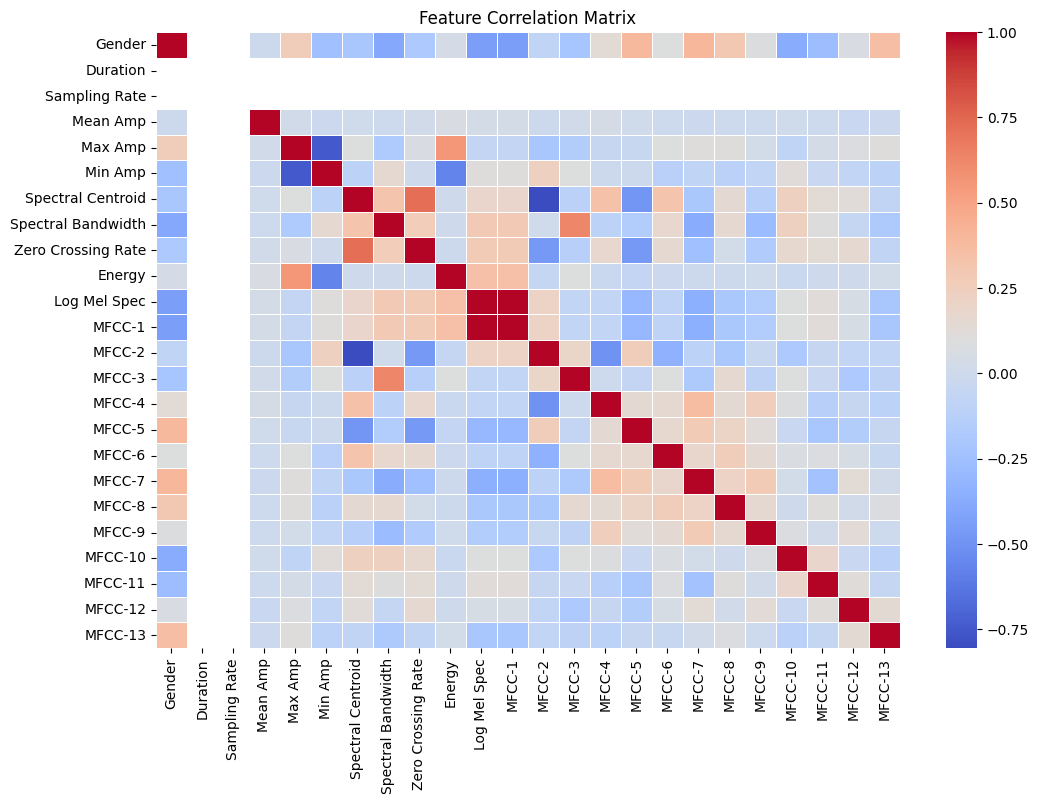


Correlation between Gender and Features (sorted):
MFCC-7                0.401076
MFCC-5                0.392184
MFCC-13               0.360929
MFCC-8                0.296276
Max Amp               0.257654
MFCC-4                0.135979
MFCC-6                0.094207
MFCC-9                0.084292
MFCC-12               0.062423
Energy                0.033772
Mean Amp             -0.009874
MFCC-2               -0.086223
Zero Crossing Rate   -0.191635
Spectral Centroid    -0.205353
MFCC-3               -0.219496
Min Amp              -0.253060
MFCC-11              -0.271106
MFCC-10              -0.373900
Spectral Bandwidth   -0.389935
MFCC-1               -0.441473
Log Mel Spec         -0.441499
Duration                   NaN
Sampling Rate              NaN
Name: Gender, dtype: float64


In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

gender_correlation = correlation_matrix["Gender"].drop("Gender").sort_values(ascending=False)

print("\nCorrelation between Gender and Features (sorted):")
print(gender_correlation)

Strong Positive Correlation:

* MFCC-7 (0.40): This Mel-Frequency Cepstral Coefficient has the strongest positive correlation with gender. A higher value of MFCC-7 is more likely associated with male voices.
* MFCC-5 (0.39), MFCC-13 (0.36), MFCC-8 (0.29): These MFCCs also show a significant positive correlation, indicating their potential for distinguishing between genders.
* Max Amp (0.26): Maximum amplitude, related to the loudness of the audio, shows a moderate positive correlation. Male voices might tend to have higher maximum amplitudes.

Moderate Positive Correlation:

* MFCC-4 (0.14), MFCC-6 (0.09), MFCC-9 (0.08), MFCC-12 (0.06), Energy (0.03): These features have a weak to moderate positive correlation with gender.

Weak or No Correlation:

* Mean Amp (-0.01): The average amplitude of the signal shows almost no correlation with gender, suggesting that it's not a strong indicator for gender classification.

Negative Correlation:

* MFCC-2 (-0.09), Zero Crossing Rate (-0.19), Spectral Centroid (-0.21), MFCC-3 (-0.22), Min Amp (-0.25), MFCC-11 (-0.27), MFCC-10 (-0.37), Spectral Bandwidth (-0.39), MFCC-1 (-0.44), Log Mel Spec (-0.44): These features exhibit a negative correlation with gender. A lower value of these features is more likely associated with male voices. Notably, MFCC-1 and Log Mel Spec have the strongest negative correlations.

NaN (Not a Number):

* Duration, Sampling Rate: The correlation values for duration and sampling rate are NaN, which means there's no variation in these features within the dataset, or there are issues with the data causing the calculation to fail. These features are likely not helpful for gender classification in this context.


We select features with strong and moderate positive correlation

In [ ]:
selected_features = [
    "MFCC-7",
    "MFCC-5", "MFCC-13",
    "MFCC-8", "Max Amp", "MFCC-4",
    "MFCC-6", "MFCC-9", "MFCC-12",
    "Energy",
]

As the performance of models we experimented were acceptable, we didn't test any other method for feature reduction. Howevere, in the following a few well-know are implemented, and described.

#### RFE

Recursive Feature Elimination (RFE) is a feature selection technique that recursively removes the least important features based on a given estimator (e.g., a classifier or regression model). It helps to identify the most relevant features for improving model performance.

The following function uses `RandomForestClassifier` as the estimator (baseline model) for ranking feature importance. Then, the `RFE` object is set up to select the top 5 most important features from the dataset. It iteratively removes the least important features until only 5 remain to fir RFE on the training data. Finally, it extracts and prints the names of the top 5 features that contribute most to prediction.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Define a baseline model for feature selection (Random Forest works well)
estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Use RFE to find the best features
selector = RFE(estimator, n_features_to_select=5, step=1)  # Select top 5 features
selector.fit(X_train, y_train)

# Get selected feature names
selected_features = [feature for feature, selected in zip(df.columns[3:], selector.support_) if selected]
print("Selected Features:", selected_features)

Selected Features: ['Duration', 'Mean Amp', 'Max Amp', 'Spectral Bandwidth', 'Log Mel Spec']


#### Using Feature Importance From Random Forest

Random Forest provides a measure of feature importance based on how much each feature contributes to reducing impurity (e.g., Gini impurity or entropy) in decision trees. Features with higher importance values have a greater impact on predictions. By selecting only the most important features, we can reduce dimensionality, improve model efficiency, and potentially enhance generalization.

The following function extracts feature importance scores from a trained `RandomForestClassifier`. It creates a DataFrame with feature names and their corresponding importance values, sorts them in descending order, and prints the top 10 features. Finally, it selects the top 5 most important features for further use in model training.

In [ ]:
importances = estimator.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": df.columns[3:], "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print(feature_importance_df.head(10))  # Top 10 features
selected_features = feature_importance_df["Feature"].head(5).tolist()  # Pick top 5

#### Mutual Information

Mutual Information (MI) measures the dependency between two variables. In the context of feature selection, it quantifies how much information a feature provides about the target variable. A higher MI score indicates a stronger relationship between the feature and the target, making it more relevant for prediction. Unlike linear correlation, MI can capture non-linear dependencies.

The following function computes the Mutual Information (MI) scores for all features in `X_train` with respect to `y_train`. It stores the scores in a DataFrame, sorts the features by MI score in descending order, and prints the top 10 most informative features. Finally, it selects the top 5 features with the highest MI scores for further model training.

In [ ]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train, y_train)
print(len(mi_scores))
mi_df = pd.DataFrame({"Feature": df.columns[3:], "MI Score": mi_scores})
mi_df = mi_df.sort_values(by="MI Score", ascending=False)

print(mi_df.head(10))  # Top 10 features
selected_features = mi_df["Feature"].head(5).tolist()  # Pick top 5

#### Feature Combination

In [ ]:
df["MFCC 7/8 Ratio"] = df["MFCC-7"] / (df["MFCC-8"] + 1e-6)
df["MFCC 5-6 Diff"] = df["MFCC-5"] - df["MFCC-6"]
selected_features += ["MFCC 7/8 Ratio", "MFCC 5-6 Diff"]

df["SpecBW*MinAmp"] = df["Spectral Bandwidth"] * df["Min Amp"]
selected_features.append("SpecBW*MinAmp")

#### PCA

Principal Component Analysis (PCA) is a technique used to reduce the dimensionality of a dataset while preserving as much variance as possible. It transforms the original features into a new set of uncorrelated components (principal components) that capture the most significant patterns in the data. PCA is useful for improving computational efficiency, reducing noise, and preventing overfitting.

The following function applies PCA to reduce the dataset to its top 5 principal components. It first initializes PCA with `n_components=5`, specifying that the dataset should be reduced to 5 principal components. Then, it fits PCA on `X_train` and transforms it to extract the 5 most significant components. The same transformation is applied to `X_test` using the trained PCA model. Finally, it prints the explained variance ratio, which shows the proportion of variance retained by each of the 5 components, helping to evaluate how much information is preserved after dimensionality reduction.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # Reduce to top 5 components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.21952304 0.15207852 0.08709308 0.07825895 0.06294273]


### Feature Selection

Here, we separate the selected features to form X_train and X_test. We also form y_train and y_test by just looking at the Gender feature.

In [ ]:
X_train = train_df[selected_features].values  # Exclude "Gender"
y_train = train_df["Gender"].values  # Target (Gender)

X_test = test_df[selected_features].values
y_test = test_df["Gender"].values

### Define Models

The following models were selected for their ability to capture various patterns and complexities in the data:

- **Logistic Regression**: A simple yet effective baseline model that works well when the features are linearly separable. It provides interpretability and can serve as a benchmark for performance comparison.
- **Random Forest**: A powerful ensemble method that handles non-linearity and feature interactions well. It is robust to noise, provides feature importance scores, and works well with structured tabular data extracted from audio signals.
- **K-Nearest Neighbors (KNN)**: A non-parametric model that classifies based on similarity to nearby data points. Since gender differences in audio features may form natural clusters, KNN can be useful when sufficient data is available.
- **Multi-Layer Perceptron (MLP)**: A neural network model that can learn complex, non-linear relationships in the data. With hidden layers, it can effectively capture deep patterns in audio features, making it suitable for more complex datasets.

Note: We didn't use SVM (as you can see), because it does not typically give probabilities which is required for ploting the ROC curve.

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "SVM": SVC(kernel="linear"),
    "KNN": KNeighborsClassifier(n_neighbors=5),  # k=5 as default
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
}

### Train and Test

We use `X_train` and `y_train` for training model, and `X_test` and `y_test` for evaluating its performance. We use classification_report, ROC curve, and Confusion Matrix to show the performance in order to simplifying analyzing them.

Note: Codes for ploting the ROC curve and Confusion Matrix are AI-generated (ChatGPT).

          Logistic Regression           
Accuracy: 0.8489
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       235
           1       0.87      0.83      0.85       235

    accuracy                           0.85       470
   macro avg       0.85      0.85      0.85       470
weighted avg       0.85      0.85      0.85       470



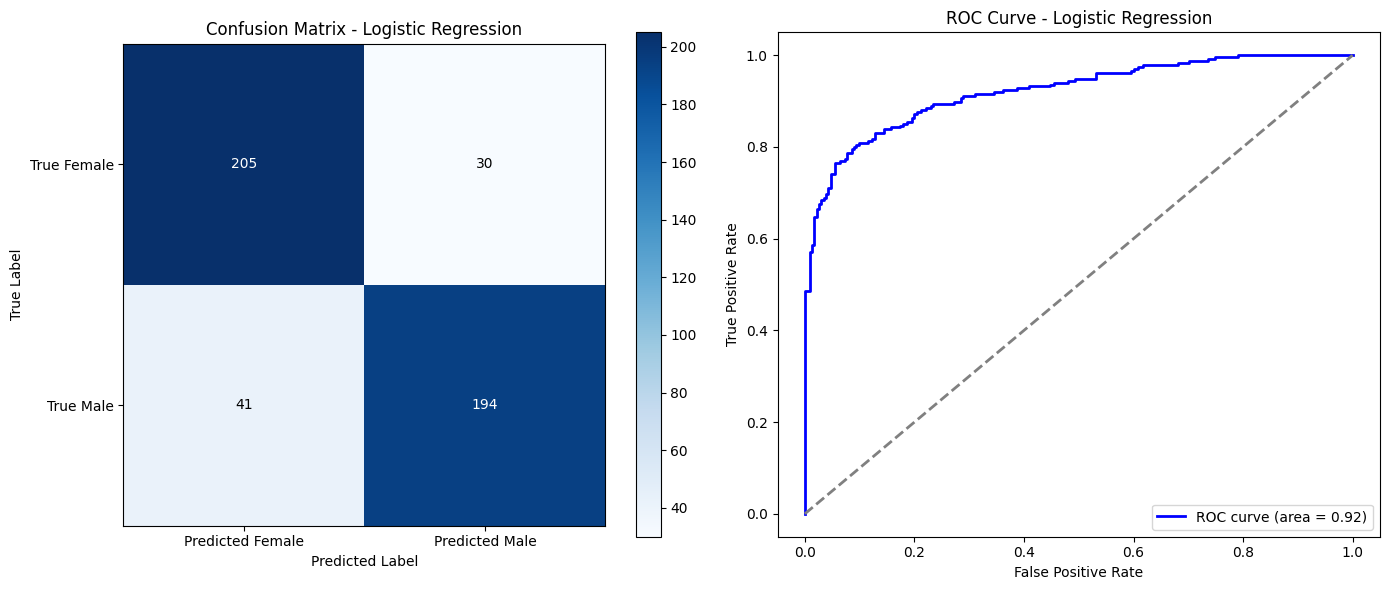

             Random Forest              
Accuracy: 0.8787
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       235
           1       0.91      0.84      0.87       235

    accuracy                           0.88       470
   macro avg       0.88      0.88      0.88       470
weighted avg       0.88      0.88      0.88       470



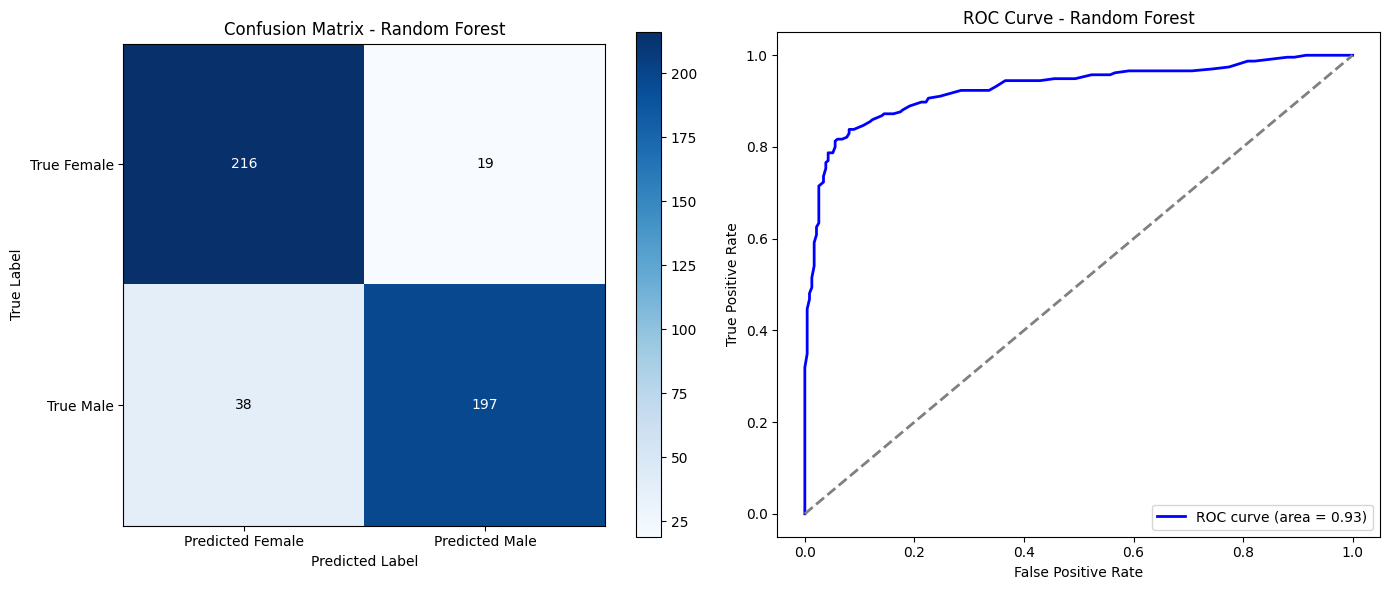

                  KNN                   
Accuracy: 0.8298
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.93      0.84       235
           1       0.91      0.73      0.81       235

    accuracy                           0.83       470
   macro avg       0.84      0.83      0.83       470
weighted avg       0.84      0.83      0.83       470



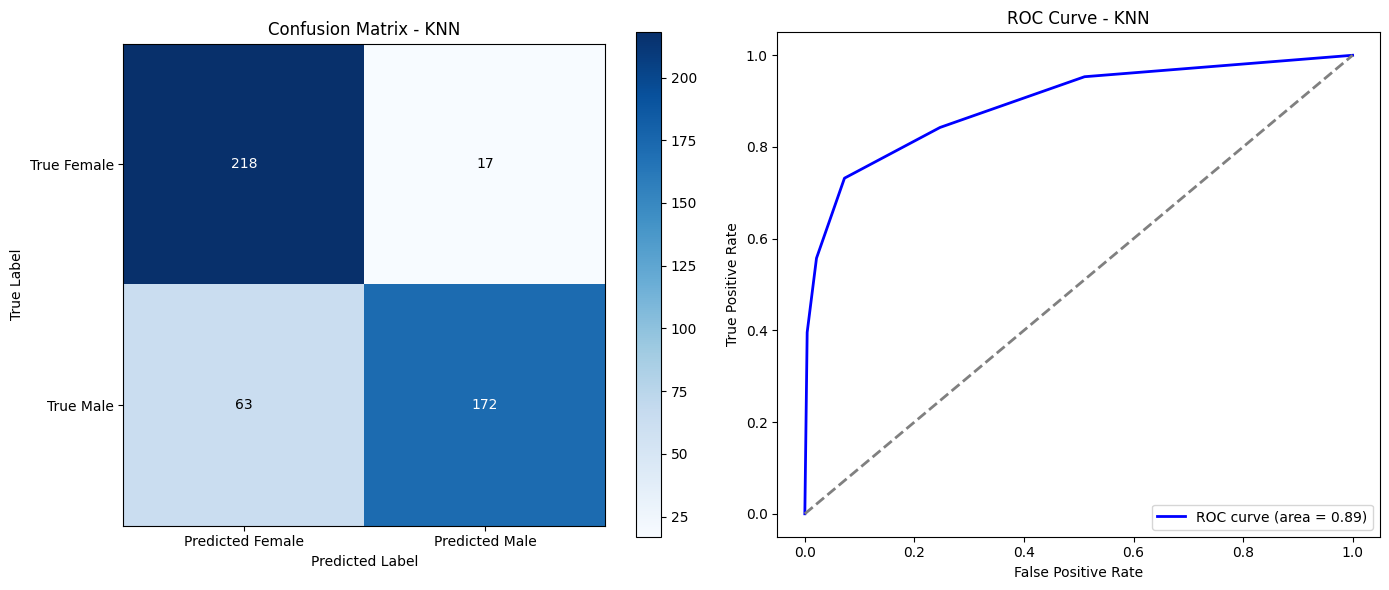

                  MLP                   
Accuracy: 0.8191
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       235
           1       0.83      0.80      0.82       235

    accuracy                           0.82       470
   macro avg       0.82      0.82      0.82       470
weighted avg       0.82      0.82      0.82       470



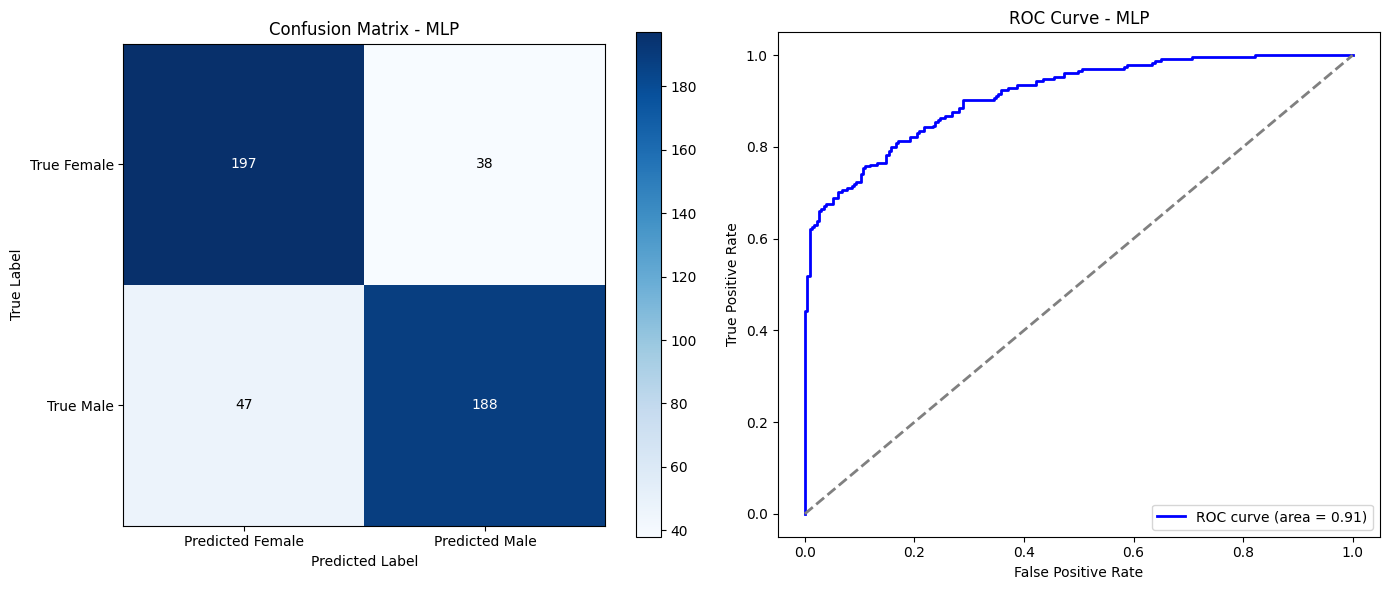

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Make predictions

    # Print classification results with better formatting
    print("="*50)
    print(f"{name:^40}")
    print("="*50)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("-"*50)
    print("Classification Report:")
    print("-"*50)
    print(classification_report(y_test, y_pred))
    print("="*50)

    # AI-Generated codes:

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot both confusion matrix and ROC curve side by side
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Confusion matrix on the left
    axs[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axs[0].set_title(f"Confusion Matrix - {name}")
    cbar = axs[0].figure.colorbar(axs[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues), ax=axs[0])
    axs[0].set_xticks([0, 1])
    axs[0].set_yticks([0, 1])
    axs[0].set_xticklabels(['Predicted Female', 'Predicted Male'])
    axs[0].set_yticklabels(['True Female', 'True Male'])
    for i in range(2):
        for j in range(2):
            axs[0].text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max() / 2 else "black")
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('True Label')

    # ROC curve on the right
    if len(np.unique(y)) == 2:  # Ensure binary classification
        y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        axs[1].plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        axs[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        axs[1].set_xlabel('False Positive Rate')
        axs[1].set_ylabel('True Positive Rate')
        axs[1].set_title(f'ROC Curve - {name}')
        axs[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

#### Analysis

**Analyzing Algorithm**
   * **Logistic Regression** achieved an overall accuracy of 84.89%. The model shows a balanced performance across both classes with precision, recall, and F1-scores all around 0.85. This indicates that the model performs equally well in identifying both male and female genders. However, slightly higher recall for Class 0 indicates that it correctly identifies more instances of Class 0.
   * **Random Forest** achieved the highest accuracy at 87.87%. It demonstrates high precision and recall, particularly for class 0 (female). High precision for Class 1 means when the model predicts Class 1, it is correct 91% of the time. High recall for Class 0 indicates it captures 92% of all actual Class 0 instances. The F1-scores are also strong, indicating that this model is effective at classifying both genders, with slightly better performance on the female class.
      * F1-Scores are the highest among all models.
   * **KNN** achieved an accuracy of 82.98%. The model shows a high recall for class 0 (female) but lower recall for class 1 (male), so there is an imbalance between precision and recall across classes. Also, Precision is relatively high for class 1. The F1-scores indicate that the model performs reasonably well, but there is a trade-off between precision and recall across the two classes.
      * The model tends to classify more instances as Class 0, which may lead to false positives in that class.
   * **MLP** achieved an accuracy of 81.91%. The model shows consistent performance across both classes with balanced precision, recall, and F1-scores around 0.82. This suggests that MLP is reliable in classifying both genders but has slightly lower performance compared to other models.
      * Slightly lower scores compared to Logistic Regression and Random Forest.

**Comparing Algorithms**
   * Among the four models, Random Forest performed the best with the highest accuracy (87.87%) and strong precision and recall values, especially for class 0 (female). Logistic Regression also showed balanced performance with an accuracy of 84.89%. Both KNN and MLP demonstrated reasonable performance but with certain trade-offs between precision and recall. These results suggest that Random Forest may be the most effective model, given its high accuracy and robust classification metrics.

**Analyzing the ROC Curves**
   * **Logistic Regression**
     * Area Under the Curve (AUC): The AUC for this Logistic Regression model is 0.92, indicating an excellent performance in distinguishing between the two classes.
     * The blue ROC curve rises sharply towards the top-left corner of the plot. This indicates that the model achieves a high True Positive Rate with a low False Positive Rate across different thresholds.
     * The diagonal dashed line represents a random classifier with an AUC of 0.5. The ROC curve for the Logistic Regression model is significantly above this line, further confirming its superior performance.
   * **Random Forest**
     * The AUC for this Random Forest model is 0.93, indicating a high level of performance in distinguishing between the two classes.
     * The blue ROC curve rises sharply towards the top-left corner of the plot. This indicates that the model achieves a high True Positive Rate with a low False Positive Rate across different thresholds.
     * The diagonal dashed line represents a random classifier with an AUC of 0.5. The ROC curve for the Random Forest model is significantly above this line, further confirming its superior performance.
   * **KNN**
     * The AUC for this KNN model is 0.89, indicating a high level of performance in distinguishing between the two classes.
     * The blue ROC curve rises sharply towards the top-left corner of the plot. This indicates that the model achieves a high True Positive Rate with a low False Positive Rate across different thresholds.
     * The diagonal dashed line represents a random classifier with an AUC of 0.5. The ROC curve for the KNN model is significantly above this line, further confirming its superior performance.
   * **MLP**
     * The AUC for this MLP model is 0.91, indicating a high level of performance in distinguishing between the two classes.
     * The blue ROC curve rises sharply towards the top-left corner of the plot. This indicates that the model achieves a high True Positive Rate with a low False Positive Rate across different thresholds.
     * The diagonal dashed line represents a random classifier with an AUC of 0.5. The ROC curve for the MLP model is significantly above this line, further confirming its superior performance.

## Part 2.2: Closed-Set Authentication

### Constants

In [17]:
NUM_SELECTED_FRAMES = 600
NUM_STUDENTS = 6
NUM_ROUNDS = 3

### Feature Extraction

Before get started, let's see each student has how many frames. We do this calculation by comparing the number with 600 (`NUM_SELECTED_FRAMES`).

In [18]:
i = 0
j = 0
k = 0
while i < len(train_frames):
    if train_frames[i][0].shape[1] >= 600:
        j += 1
    else:
        k += 1
    i += 1

print(f"Num of students with more than 400 frames: {j}")
print(f"Num of students with less than 400 frames: {k}")

Num of students with more than 400 frames: 44
Num of students with less than 400 frames: 51


As we want to have 600 frames of each student, first, we exclude all the students with less than 600 recorded frames. Again, due to the resource limitation, this is done in-place.

In [19]:
i = 0
while i < len(train_frames):
    if train_frames[i][0].shape[1] < 600:
        del train_frames[i]
    else:
        i += 1

print(f"Updated train_frames size: {len(train_frames)}")

Updated train_frames size: 44


Now, we randomly select 6 students from the remaining ones for three times, and extract features of 600 randomly selected of their recorded frames (this is done in `extract_features_from_frames`).

In [20]:
dfs = []

for i in range(NUM_ROUNDS):
    random.shuffle(train_frames)
    dfs.append(extract_features_from_frames(train_frames[:NUM_STUDENTS], NUM_SELECTED_FRAMES))

#### Feature Values: String to Number

As all feature values are `string`, and to calculate the correlation matrix we need numercial values, we turn these stings to numbers. We use `regex` here, to extract the numbers in strings (this is because some of them are followed by a measuring unit, eg., 1.2 s).

In [21]:
# Drop categorical Gender
for i in range(NUM_ROUNDS):
    dfs[i] = dfs[i].drop(columns=["Gender"])

# Convert all numerical columns from string (if needed)
for i in range(NUM_ROUNDS):
    for col in dfs[i].columns[3:]:  # Skip Student ID, Gender, and Frame ID
        dfs[i][col] = dfs[i][col].astype(str).str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)

# Convert Student ID column from string
for i in range(NUM_ROUNDS):
    dfs[i]["Student ID"] = dfs[i]["Student ID"].astype(str).str.extract(r'([-+]?\d*\.\d+|\d+)').astype(float)

#### Show the Data Frames

In [22]:
dfs[0]

Student ID    Frame ID Duration  Sampling Rate  Mean Amp   Max Amp  \
0     810103241.0   Frame 231   1.16 s        44100.0  -0.01070  16.21875   
1     810103241.0    Frame 16   1.16 s        44100.0   0.00289  11.53125   
2     810103241.0   Frame 258   1.16 s        44100.0  -0.00526  19.70312   
3     810103241.0  Frame 1038   1.16 s        44100.0   0.00055  22.01562   
4     810103241.0   Frame 279   1.16 s        44100.0  -0.00428  22.60938   
...           ...         ...      ...            ...       ...       ...   
3595  810100590.0  Frame 1272   1.16 s        44100.0   0.00655   8.28125   
3596  810100590.0  Frame 1275   1.16 s        44100.0   0.00198  10.10938   
3597  810100590.0  Frame 1030   1.16 s        44100.0   0.00415   8.72656   
3598  810100590.0  Frame 1433   1.16 s        44100.0  -0.00079   7.89844   
3599  810100590.0   Frame 714   1.16 s        44100.0  -0.00360   8.05469   

       Min Amp  Spectral Centroid  Spectral Bandwidth  Zero Crossing Rate  \
0    -14.63281            4025.39             4134.51             0.09471   
1    -11.30469            4324.54             3998.24             0.12490   
2    -15.89062            4308.36             4067.41             0.11034   
3    -18.21875            4225.20             3834.48             0.08877   
4    -21.56250            3803.14             3749.93             0.10686   
...        ...                ...                 ...                 ...   
3595 -10.39844            3222.69             4360.63             0.08143   
3596  -9.94531            3296.38             4319.21             0.07803   
3597  -7.31250            3465.51             4390.04             0.08048   
3598  -7.51562            3591.41             4452.88             0.08834   
3599  -7.75000            3280.71             4056.42             0.08403   

      ...  MFCC-4  MFCC-5  MFCC-6  MFCC-7  MFCC-8  MFCC-9  MFCC-10  MFCC-11  \
0     ...   18.58   -4.72    5.96   -8.44   -4.36  -11.28     1.91     0.72   
1     ...   20.48   -0.06   11.29   -4.81    0.21  -11.61     2.66    -0.76   
2     ...   25.40    3.51    7.42   -1.94   -3.23  -10.45     3.23    -1.79   
3     ...    9.93   -0.60   -3.41   -7.09    0.99  -10.50    -0.74    -1.61   
4     ...   22.00    0.60    9.14   -0.81   -0.79  -11.90    -1.69    -3.47   
...   ...     ...     ...     ...     ...     ...     ...      ...      ...   
3595  ...   23.72   -0.43    0.99  -14.33   -4.62   -6.38    -2.75    -2.51   
3596  ...   26.23   -0.10    3.72  -16.32   -1.91   -6.19    -2.67    -2.41   
3597  ...   26.16    3.45    0.43  -11.12   -5.26  -10.39    -2.38    -2.81   
3598  ...   21.07   -2.06   -4.44  -13.69   -7.09   -9.22    -2.25    -0.98   
3599  ...   16.64   -6.55   -6.17  -17.23  -14.76  -10.86    -5.14    -3.80   

      MFCC-12  MFCC-13  
0        3.09    -6.90  
1        0.43    -6.43  
2        3.47    -5.83  
3        5.37    -8.69  
4        4.75    -2.56  
...       ...      ...  
3595    -2.29    -1.42  
3596    -3.40    -3.02  
3597    -2.52    -5.46  
3598    -2.26    -0.73  
3599     1.21    -2.10  

[3600 rows x 25 columns]

In [23]:
dfs[1]

Student ID    Frame ID Duration  Sampling Rate  Mean Amp   Max Amp  \
0     810102027.0  Frame 2578   1.16 s        44100.0  -0.00992   5.83594   
1     810102027.0    Frame 71   1.16 s        44100.0  -0.00126  11.47656   
2     810102027.0   Frame 524   1.16 s        44100.0  -0.00847   8.00781   
3     810102027.0  Frame 2192   1.16 s        44100.0   0.00187   6.22656   
4     810102027.0   Frame 220   1.16 s        44100.0  -0.00161   7.24609   
...           ...         ...      ...            ...       ...       ...   
3595  810101551.0  Frame 2443   1.16 s        44100.0   0.00220   9.97656   
3596  810101551.0  Frame 1002   1.16 s        44100.0  -0.00289  10.96875   
3597  810101551.0   Frame 576   1.16 s        44100.0  -0.00223   6.49219   
3598  810101551.0  Frame 2165   1.16 s        44100.0   0.00194   8.42969   
3599  810101551.0  Frame 1543   1.16 s        44100.0   0.00601  12.73438   

       Min Amp  Spectral Centroid  Spectral Bandwidth  Zero Crossing Rate  \
0     -4.71484            2810.53             3889.13             0.05947   
1    -10.14844            2994.24             3917.38             0.09089   
2     -8.00781            2362.77             3824.06             0.04669   
3     -4.52734            2873.13             4146.39             0.08099   
4     -5.67578            2735.50             3872.03             0.06869   
...        ...                ...                 ...                 ...   
3595  -5.91797            2850.06             4039.53             0.07521   
3596  -7.01562            3487.94             3929.68             0.07711   
3597  -5.83203            3657.60             3970.25             0.09834   
3598  -6.83203            3669.95             4166.25             0.07963   
3599  -6.37500            3770.55             4066.76             0.09154   

      ...  MFCC-4  MFCC-5  MFCC-6  MFCC-7  MFCC-8  MFCC-9  MFCC-10  MFCC-11  \
0     ...    4.72   -8.19   -7.45   -8.38   -7.82   -9.26    -0.06    -1.02   
1     ...    7.91    3.96   -4.18   -4.78   -8.27  -11.17    -1.25    -2.68   
2     ...   -3.25    0.78   -2.68   -6.88   -7.31  -10.19    -5.37    -0.20   
3     ...    9.97   -6.81  -12.05   -3.42   -3.74  -10.32    -0.98     1.80   
4     ...    0.31    0.95   -8.28   -8.08   -8.54  -13.58    -3.49     1.05   
...   ...     ...     ...     ...     ...     ...     ...      ...      ...   
3595  ...    6.51   -5.73   -8.10  -15.54  -14.03  -10.77    -4.91    -2.00   
3596  ...   31.76  -10.29   -8.99   -8.49  -11.18   -3.31    -5.03    -7.39   
3597  ...   30.10  -19.86   -8.46   -6.47  -14.64   -7.72    -1.31    -5.01   
3598  ...   24.51   -9.23   -1.75   -8.10  -11.42  -11.99    -6.07    -3.50   
3599  ...   27.01  -14.05   -4.11  -10.43  -13.90   -4.32    -1.61    -7.53   

      MFCC-12  MFCC-13  
0       -1.66    -0.91  
1       -5.16    -3.36  
2       -1.76    -3.87  
3       -2.09    -5.16  
4       -0.80    -4.31  
...       ...      ...  
3595     2.78    -3.59  
3596     1.46    -4.31  
3597     2.55    -4.80  
3598     3.66    -3.73  
3599     2.52    -6.79  

[3600 rows x 25 columns]

In [24]:
dfs[2]

Student ID    Frame ID Duration  Sampling Rate  Mean Amp   Max Amp  \
0     810800024.0   Frame 203   1.16 s        44100.0  -0.00757  13.77344   
1     810800024.0   Frame 376   1.16 s        44100.0  -0.00586   8.82812   
2     810800024.0   Frame 114   1.16 s        44100.0   0.00101  20.64062   
3     810800024.0   Frame 389   1.16 s        44100.0   0.00278   6.62500   
4     810800024.0    Frame 73   1.16 s        44100.0   0.00422   9.63281   
...           ...         ...      ...            ...       ...       ...   
3595  159403005.0  Frame 1799   1.16 s        44100.0  -0.01049  13.75000   
3596  159403005.0  Frame 1261   1.16 s        44100.0  -0.00101  13.85938   
3597  159403005.0  Frame 1088   1.16 s        44100.0  -0.00552  14.34375   
3598  159403005.0   Frame 131   1.16 s        44100.0   0.00997  11.71875   
3599  159403005.0  Frame 1537   1.16 s        44100.0   0.00239   8.11719   

       Min Amp  Spectral Centroid  Spectral Bandwidth  Zero Crossing Rate  \
0    -12.97656            3313.60             4159.47             0.07182   
1     -8.21094            3297.70             4142.75             0.07043   
2    -18.98438            3260.51             4065.57             0.07267   
3     -6.20703            3300.63             3987.83             0.07928   
4     -6.13281            3492.88             4205.34             0.07332   
...        ...                ...                 ...                 ...   
3595 -16.76562            2518.10             3607.04             0.06184   
3596 -14.25000            3122.48             3953.80             0.07291   
3597 -12.75000            3441.32             3973.87             0.11452   
3598 -15.49219            2934.41             3978.25             0.07956   
3599 -10.95312            2628.25             3870.46             0.07502   

      ...  MFCC-4  MFCC-5  MFCC-6  MFCC-7  MFCC-8  MFCC-9  MFCC-10  MFCC-11  \
0     ...   10.75  -12.09   -1.62   -7.74  -10.13  -15.38    -5.82    -3.73   
1     ...   11.69  -12.57   -5.78  -10.02   -7.83  -13.08    -4.80    -2.93   
2     ...   19.19   -9.89   -2.16   -5.95  -10.61  -16.82    -6.34    -3.66   
3     ...   21.47  -11.33   -5.79   -9.61  -13.84  -16.83    -4.65    -1.33   
4     ...   10.43   -8.84   -2.35   -8.75   -7.18  -19.12    -5.25    -0.93   
...   ...     ...     ...     ...     ...     ...     ...      ...      ...   
3595  ...    3.29   -4.85   -9.08   -3.22   -5.80  -14.26    -9.37    -3.42   
3596  ...    9.22   -5.95   -6.46   -1.71   -9.42  -13.52    -9.23    -3.62   
3597  ...   20.51   -2.07   -0.98    1.09  -10.49  -12.34    -8.70    -7.97   
3598  ...    8.11   -5.18   -2.72   -2.38   -9.73  -17.34   -12.80   -10.70   
3599  ...    4.26   -3.56   -2.72   -2.16   -7.50  -16.42   -16.16    -7.83   

      MFCC-12  MFCC-13  
0       -0.10    -5.80  
1        2.22    -2.75  
2       -0.38    -5.59  
3       -1.37    -5.79  
4       -2.60    -5.24  
...       ...      ...  
3595    -0.82    -1.70  
3596    -2.22    -7.12  
3597    -1.32    -5.22  
3598    -1.62     0.15  
3599    -2.23    -5.91  

[3600 rows x 25 columns]

### Train and Test Splitting

Now, we split our data into two parts: train and test. To handle the balance between all classes (here, we have 6 students, hence 6 clasees), we first group data regarding `Student ID`, then split each group (i.e., all grames belonged to one student) with a ratio of 0.2 for test and 0.8 for train, and then combine all the train splits and tests splits to into `train_dfs` and `test_dfs`.

Note: We do the same process for each round.

In [39]:
# Storage for train and test data
train_list = []
test_list = []

# Splitting data while keeping the balance
for i in range(NUM_ROUNDS):
    train_list.append([])
    test_list.append([])
    for _, group in dfs[i].groupby("Student ID"):
        train, test = train_test_split(group, test_size=0.2, random_state=42, stratify=None)
        train_list[i].append(train)
        test_list[i].append(test)

# Concatenate all train and test samples
train_dfs = [pd.concat(tl).reset_index(drop=True) for tl in train_list]
test_dfs = [pd.concat(tl).reset_index(drop=True) for tl in test_list]

In the following, we print some information about `train_dfs` and `test_dfs` in order to make sure everything is fine (3600 data of each round is equally splitted into one 2800 and 720-sized parts)

In [26]:
for i in range(NUM_ROUNDS):
    print("Train Set Size:", train_dfs[i].shape)
    print("Test Set Size:", test_dfs[i].shape)

    print(train_dfs[i]["Student ID"].value_counts())
    print(test_dfs[i]["Student ID"].value_counts())

Train Set Size: (2880, 25)
Test Set Size: (720, 25)
Student ID
810100222.0    480
810100268.0    480
810100590.0    480
810102032.0    480
810103093.0    480
810103241.0    480
Name: count, dtype: int64
Student ID
810100222.0    120
810100268.0    120
810100590.0    120
810102032.0    120
810103093.0    120
810103241.0    120
Name: count, dtype: int64
Train Set Size: (2880, 25)
Test Set Size: (720, 25)
Student ID
810101551.0    480
810102027.0    480
810103262.0    480
810199328.0    480
810199570.0    480
810600065.0    480
Name: count, dtype: int64
Student ID
810101551.0    120
810102027.0    120
810103262.0    120
810199328.0    120
810199570.0    120
810600065.0    120
Name: count, dtype: int64
Train Set Size: (2880, 25)
Test Set Size: (720, 25)
Student ID
159403005.0    480
810100135.0    480
810101575.0    480
810103241.0    480
810199489.0    480
810800024.0    480
Name: count, dtype: int64
Student ID
159403005.0    120
810100135.0    120
810101575.0    120
810103241.0    120
81

### Feature Selection Algorithms

#### Naive

Because of the acceptable result of the Naive method in the previous task (gender classification), we do the same method in this task too. To achieve this goal, in a similar way to the previous section, we plot three confusion matrixes for each round for visualization. We also print a sorted list containing the correlations between all features with `Student ID`, helping us to better decide which features are better for classification.

Note: Code for ploting the Confusion Matrix is AI-generated (ChatGPT).

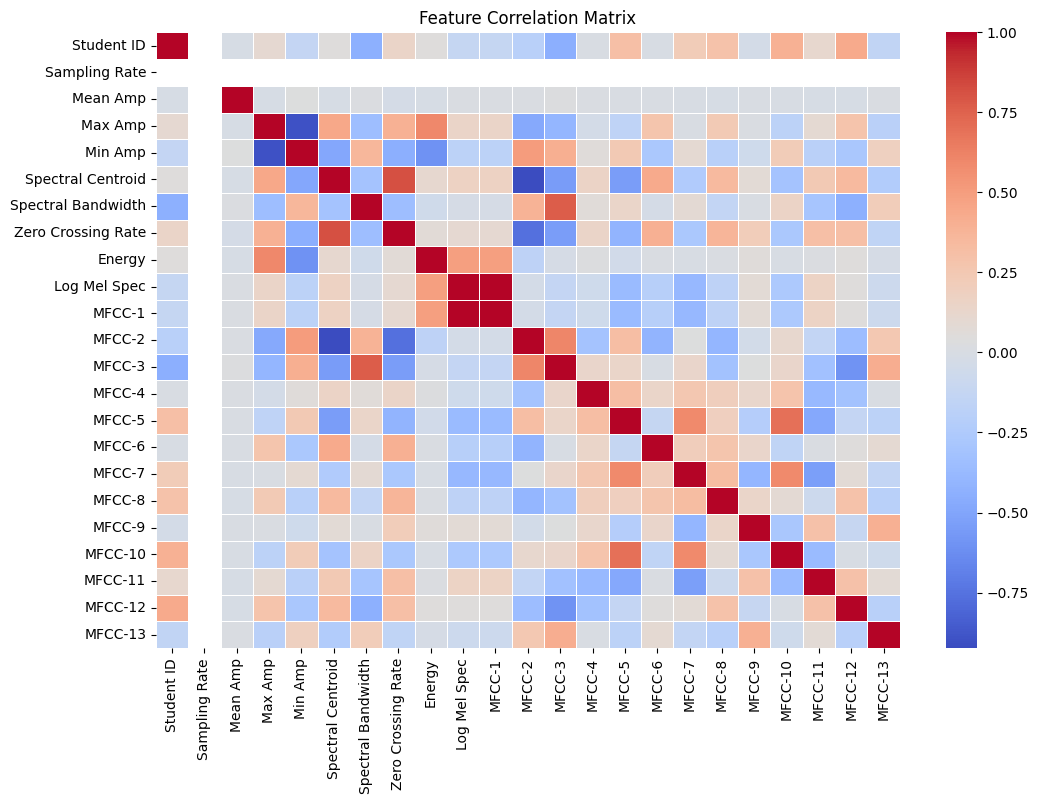


Correlation between Student ID and Features (sorted):
MFCC-12               0.435324
MFCC-10               0.393073
MFCC-5                0.315685
MFCC-8                0.288319
MFCC-7                0.220274
Zero Crossing Rate    0.147925
MFCC-11               0.116646
Max Amp               0.103311
Spectral Centroid     0.048557
Energy                0.047845
MFCC-4                0.007195
MFCC-6               -0.004133
Mean Amp             -0.012890
MFCC-9               -0.033610
Log Mel Spec         -0.124657
MFCC-1               -0.124657
Min Amp              -0.134359
MFCC-13              -0.148321
MFCC-2               -0.198847
Spectral Bandwidth   -0.437986
MFCC-3               -0.443243
Sampling Rate              NaN
Name: Student ID, dtype: float64


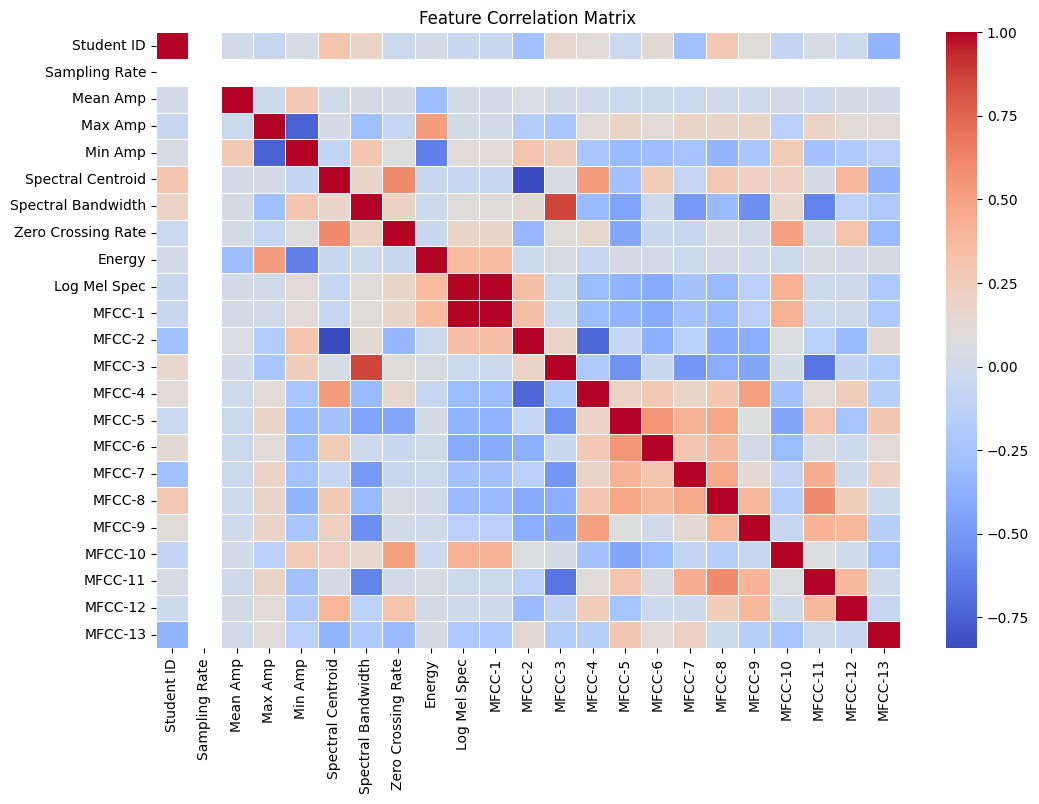


Correlation between Student ID and Features (sorted):
Spectral Centroid     0.309483
MFCC-8                0.277747
Spectral Bandwidth    0.190073
MFCC-3                0.152194
MFCC-6                0.125555
MFCC-4                0.112501
MFCC-9                0.095437
Min Amp               0.033059
MFCC-11               0.030895
Mean Amp              0.003119
Energy               -0.000155
MFCC-12              -0.023391
Zero Crossing Rate   -0.040036
MFCC-5               -0.042857
Log Mel Spec         -0.050526
MFCC-1               -0.050559
Max Amp              -0.058960
MFCC-10              -0.080288
MFCC-2               -0.269174
MFCC-7               -0.272769
MFCC-13              -0.346256
Sampling Rate              NaN
Name: Student ID, dtype: float64


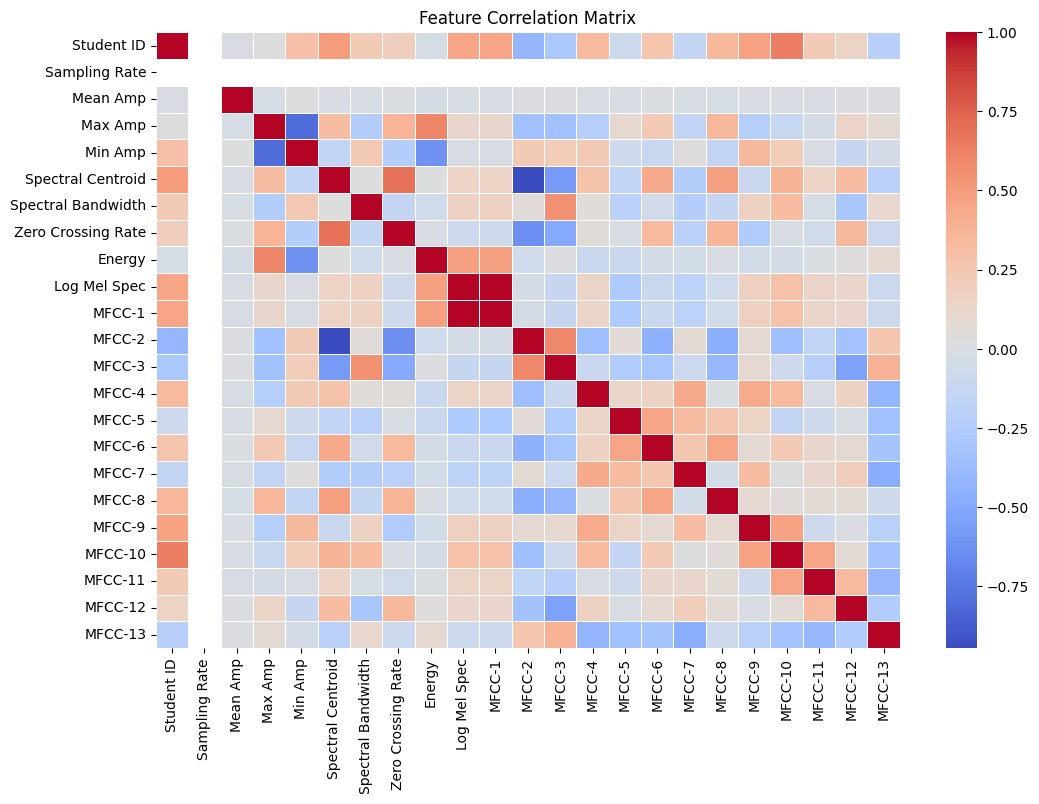


Correlation between Student ID and Features (sorted):
MFCC-10               0.634132
Spectral Centroid     0.505232
MFCC-9                0.473468
Log Mel Spec          0.454666
MFCC-1                0.454627
MFCC-8                0.353951
MFCC-4                0.333582
Min Amp               0.293477
MFCC-6                0.275138
MFCC-11               0.228422
Spectral Bandwidth    0.220540
Zero Crossing Rate    0.189025
MFCC-12               0.148226
Max Amp               0.030706
Mean Amp             -0.008925
Energy               -0.021990
MFCC-5               -0.088750
MFCC-7               -0.145433
MFCC-13              -0.216124
MFCC-3               -0.290756
MFCC-2               -0.406175
Sampling Rate              NaN
Name: Student ID, dtype: float64


In [27]:
id_correlations = []

for df in train_dfs:
    # Compute correlation matrix
    correlation_matrix = df.corr(numeric_only=True)

    # Plot correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", linewidths=0.5)
    plt.title("Feature Correlation Matrix")
    plt.show()

    # Compute correlation with Gender and sort
    id_correlation = correlation_matrix["Student ID"].drop("Student ID").sort_values(ascending=False)

    # Print sorted correlations
    print("\nCorrelation between Student ID and Features (sorted):")
    print(id_correlation)

    id_correlations.append(id_correlation)

In the following, we pick the features with a positive correlation and put them in a list for later parts of the project. We could do this automatically, as shown below, but we preferred a manual way, as it's more convenient, when we want to do trail-and-error to check if removing any feature can help the model better generalize? However, here, we didn't do that.

We also could select different features than we do by taking another objective into account (for example, considering another treshold than 0, e.g., 0.1 or 0.2), but as we reached acceptable result, we didn't consider them.

In [34]:
selected_features = [
    ['MFCC-12', 'MFCC-10', 'MFCC-5', 'MFCC-8', 'MFCC-7', "Zero Crossing Rate", 'MFCC-11', 'Max Amp', "Spectral Centroid", 'Energy', 'MFCC-4'],
    ["Spectral Centroid", "MFCC-8", "Spectral Bandwidth", "MFCC-3", "MFCC-6", "MFCC-4", "MFCC-9", "Min Amp", "MFCC-11", "Mean Amp"],
    ["MFCC-10", "Spectral Centroid", "MFCC-9", "Log Mel Spec", "MFCC-1", "MFCC-8", "MFCC-4", "Min Amp", "MFCC-6", "MFCC-11", "Spectral Bandwidth", "Zero Crossing Rate", "MFCC-12"],
]

An automatic way:

In [107]:
selected_features = []

for id_correlation in id_correlations:
    selected_features.append(id_correlation[id_correlation > 0.0].index.tolist())

### Feature Selection

Here, we separate the selected features to form `X_train` and `X_test`. We also form `y_train` and `y_test` by just looking at the `Student ID` feature. This process is done for all rounds (i.e., 3).

In [35]:
X_trains = []
y_trains = []

X_tests = []
y_tests = []

for i in range(NUM_ROUNDS):
    X_trains.append(train_dfs[i][selected_features[i]].values)
    y_trains.append(train_dfs[i]["Student ID"].values)

    X_tests.append(test_dfs[i][selected_features[i]].values)
    y_tests.append(test_dfs[i]["Student ID"].values)

### Train and Test

Just like what we did in gender classification, we consider four models:

- Logistic Regression
- Random Forest
- KNN
- MLP

We use all four models for classifying students selected for each round. We use `X_train` and `y_train` for training model, and `X_test` and `y_test` for evaluating its performance. We use `classification_report`, `ROC curve`, and `Confusion Matrix` to show the performance in order to simplifying analyzing them.

Note: Codes for ploting the ROC curve and Confusion Matrix are AI-generated (ChatGPT).

****************************************************************************************************
Round 1:
****************************************************************************************************
          Logistic Regression           
Accuracy: 0.8653
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 810100222.0       0.95      0.88      0.91       120
 810100268.0       0.98      0.99      0.98       120
 810100590.0       0.71      0.72      0.72       120
 810102032.0       0.90      0.93      0.91       120
 810103093.0       0.73      0.71      0.72       120
 810103241.0       0.93      0.96      0.94       120

    accuracy                           0.87       720
   macro avg       0.87      0.87      0.86       720
weighted avg       0.87      0.87      0.86       720



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


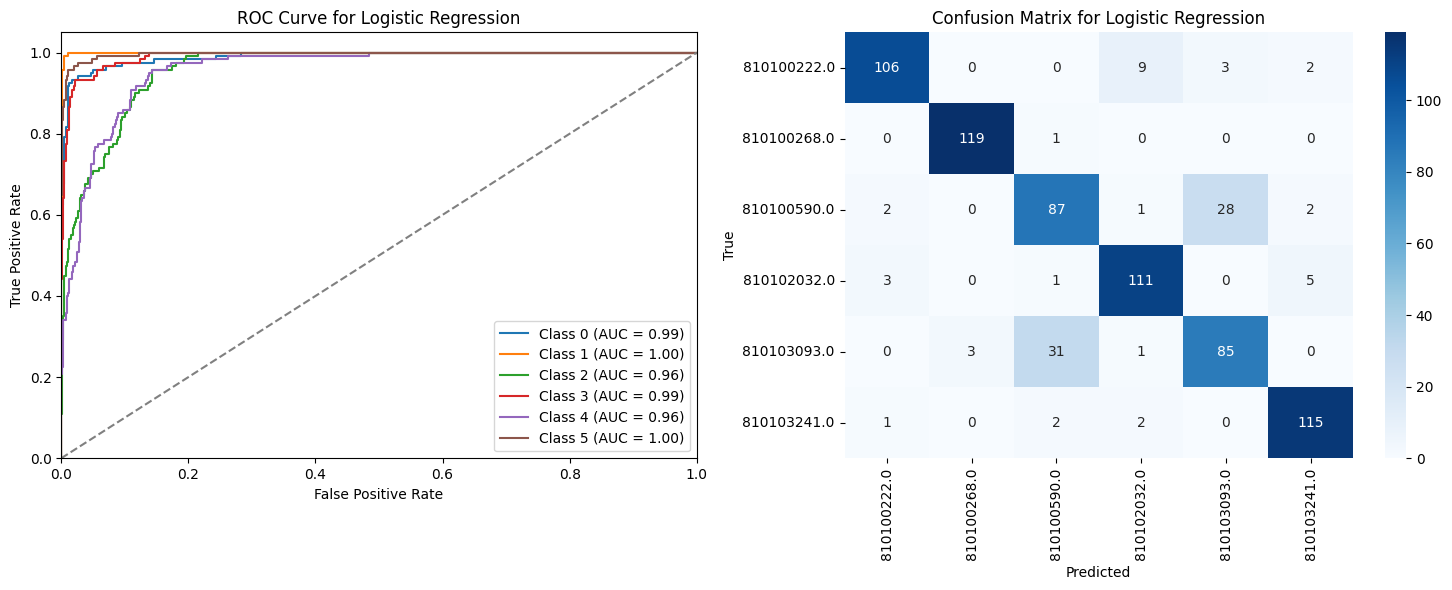

             Random Forest              
Accuracy: 0.9292
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 810100222.0       0.96      0.95      0.95       120
 810100268.0       1.00      1.00      1.00       120
 810100590.0       0.85      0.81      0.83       120
 810102032.0       0.97      0.98      0.98       120
 810103093.0       0.82      0.85      0.83       120
 810103241.0       0.98      0.98      0.98       120

    accuracy                           0.93       720
   macro avg       0.93      0.93      0.93       720
weighted avg       0.93      0.93      0.93       720



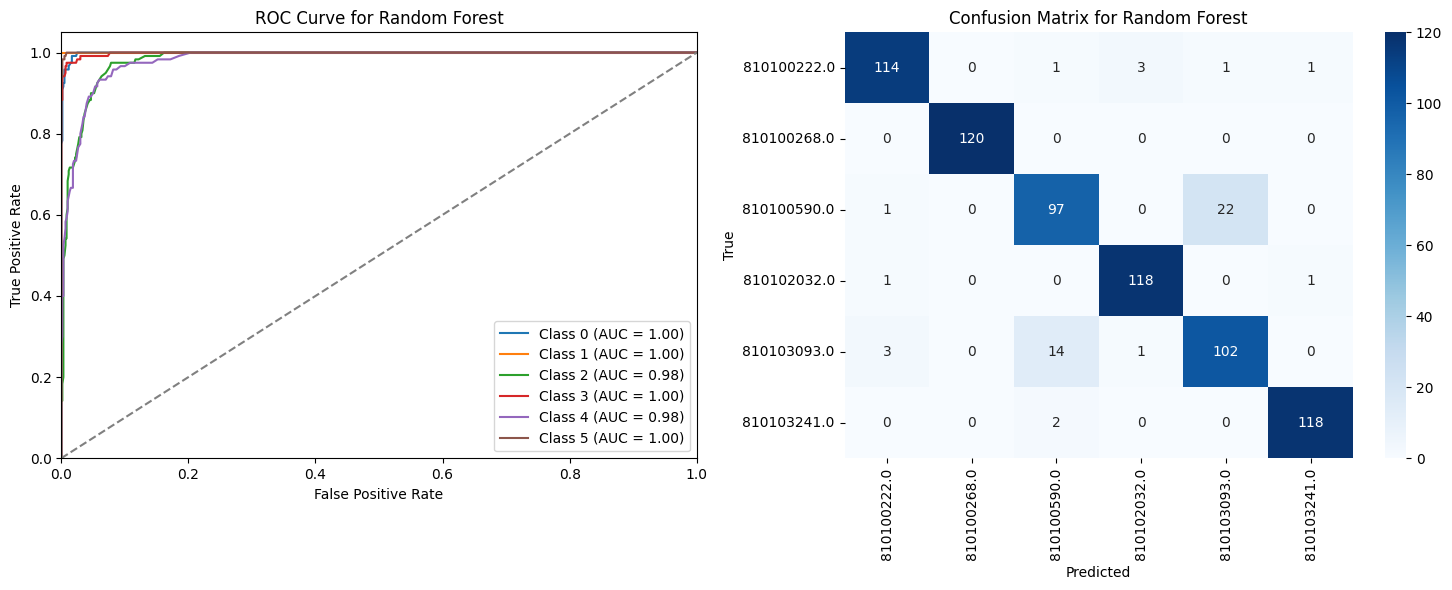

                  KNN                   
Accuracy: 0.7792
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 810100222.0       0.67      0.81      0.73       120
 810100268.0       0.94      0.96      0.95       120
 810100590.0       0.64      0.65      0.64       120
 810102032.0       0.87      0.79      0.83       120
 810103093.0       0.66      0.61      0.63       120
 810103241.0       0.92      0.86      0.89       120

    accuracy                           0.78       720
   macro avg       0.78      0.78      0.78       720
weighted avg       0.78      0.78      0.78       720



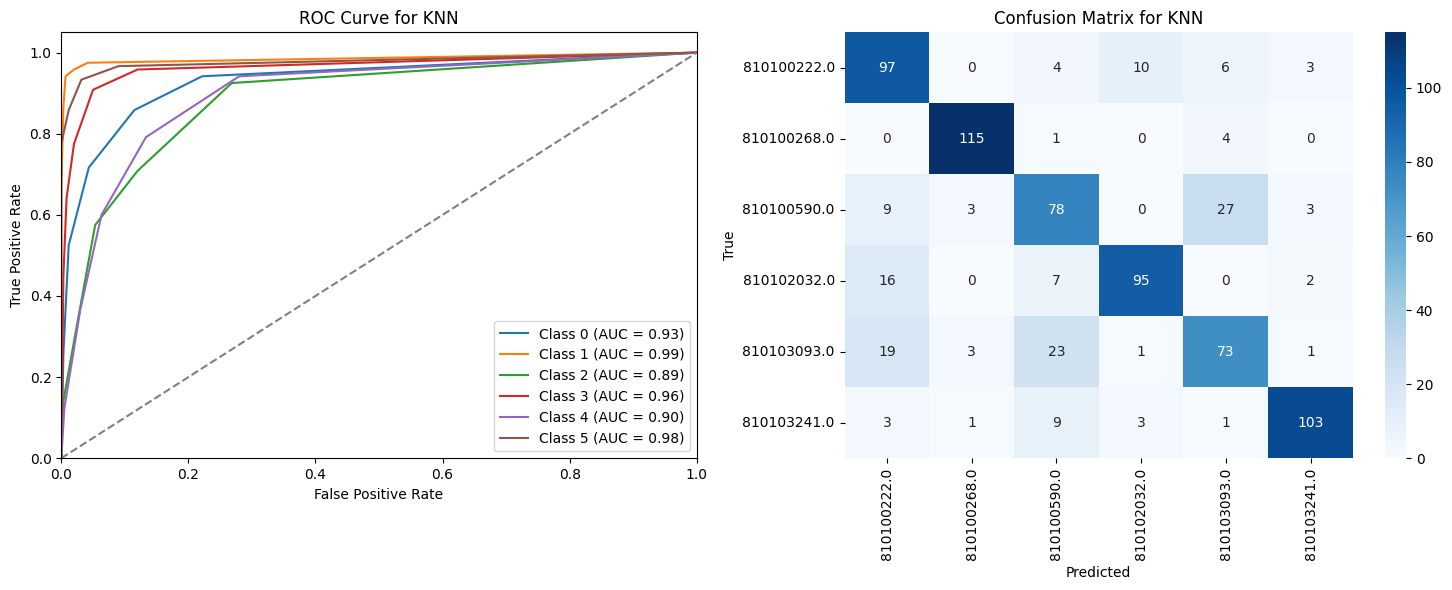

                  MLP                   
Accuracy: 0.7403
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 810100222.0       0.61      0.97      0.75       120
 810100268.0       1.00      0.73      0.85       120
 810100590.0       0.92      0.46      0.61       120
 810102032.0       1.00      0.47      0.64       120
 810103093.0       0.57      0.82      0.68       120
 810103241.0       0.77      0.98      0.86       120

    accuracy                           0.74       720
   macro avg       0.81      0.74      0.73       720
weighted avg       0.81      0.74      0.73       720



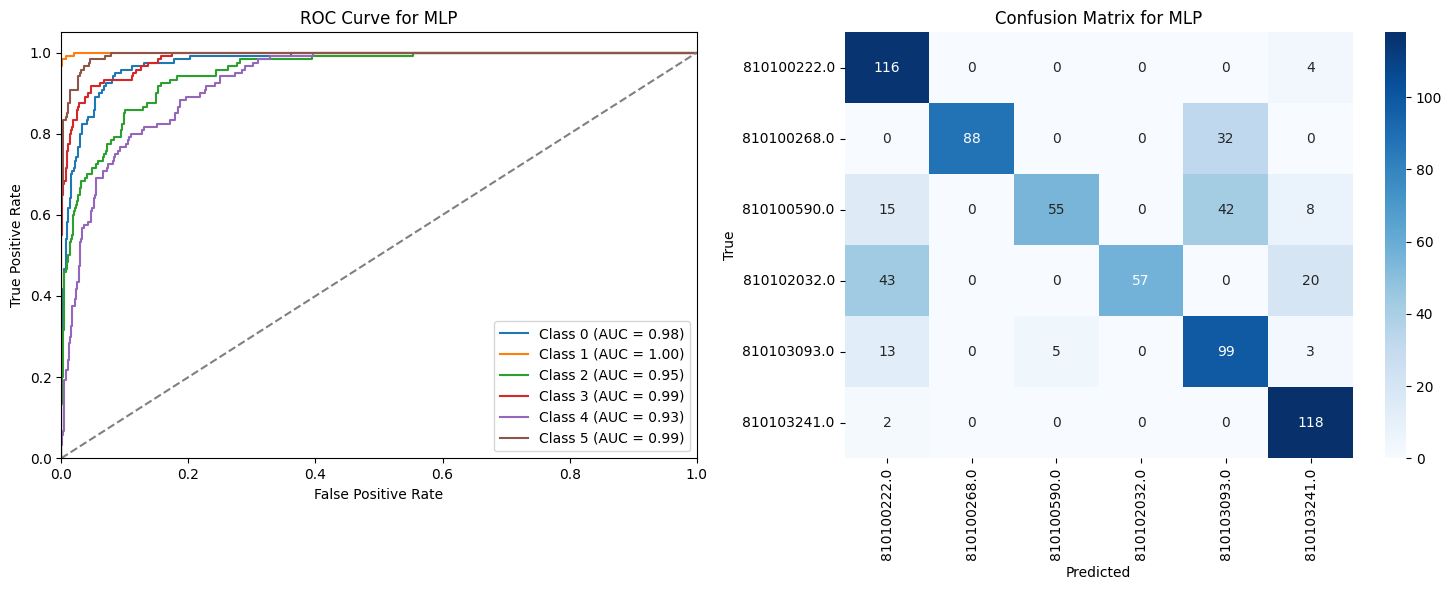

****************************************************************************************************
Round 2:
****************************************************************************************************
          Logistic Regression           
Accuracy: 0.8139
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 810101551.0       0.80      0.82      0.81       120
 810102027.0       0.84      0.78      0.81       120
 810103262.0       0.76      0.85      0.80       120
 810199328.0       0.94      0.96      0.95       120
 810199570.0       0.82      0.84      0.83       120
 810600065.0       0.71      0.62      0.67       120

    accuracy                           0.81       720
   macro avg       0.81      0.81      0.81       720
weighted avg       0.81      0.81      0.81       720



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


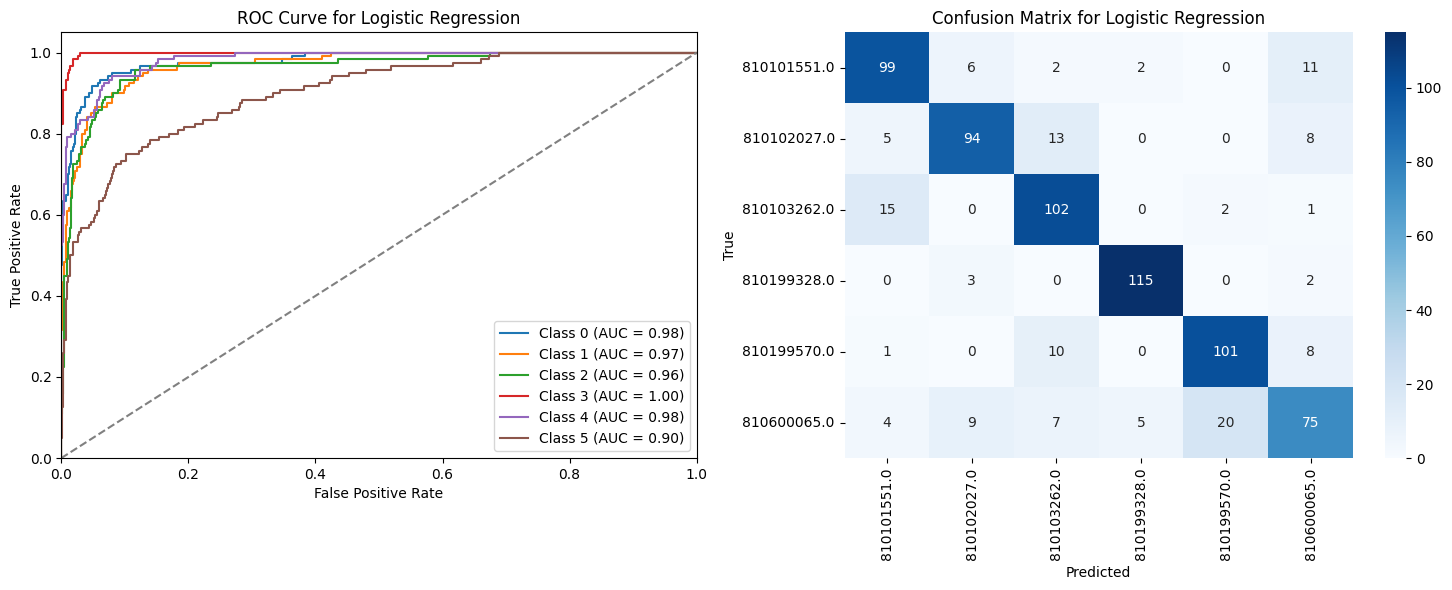

             Random Forest              
Accuracy: 0.9528
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 810101551.0       0.97      0.96      0.96       120
 810102027.0       0.97      0.96      0.96       120
 810103262.0       0.94      1.00      0.97       120
 810199328.0       1.00      1.00      1.00       120
 810199570.0       0.94      0.90      0.92       120
 810600065.0       0.91      0.90      0.90       120

    accuracy                           0.95       720
   macro avg       0.95      0.95      0.95       720
weighted avg       0.95      0.95      0.95       720



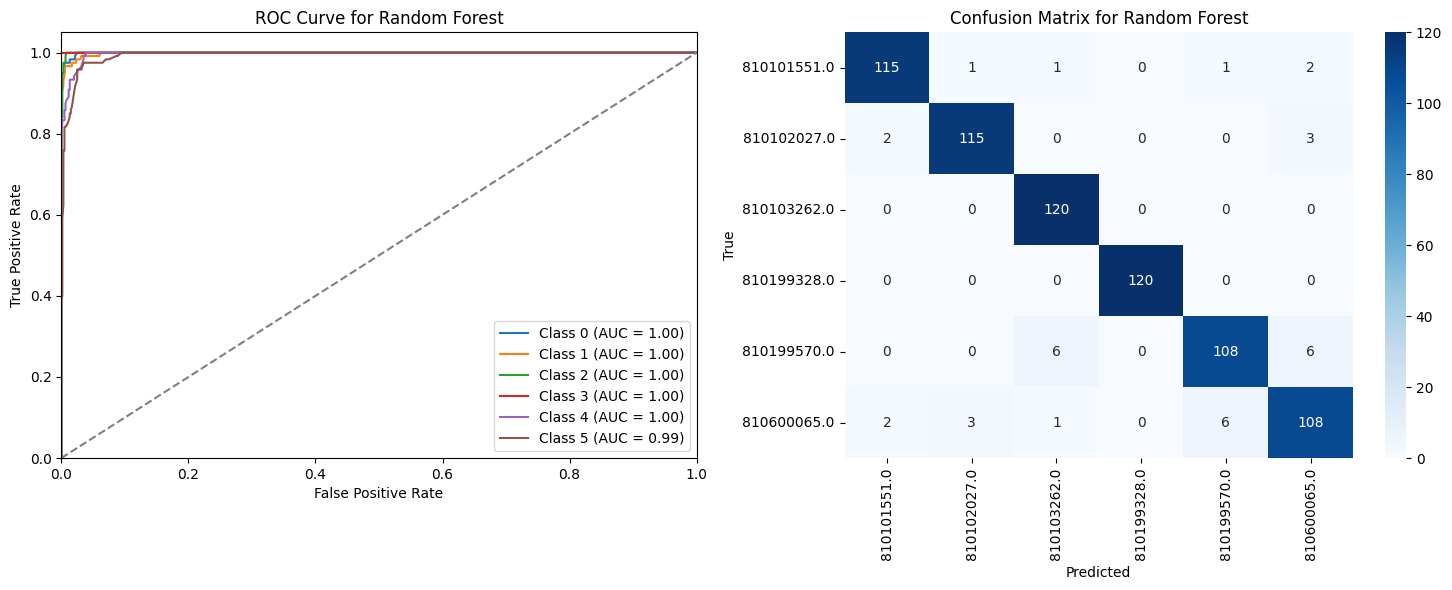

                  KNN                   
Accuracy: 0.7042
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 810101551.0       0.59      0.68      0.63       120
 810102027.0       0.68      0.64      0.66       120
 810103262.0       0.65      0.78      0.71       120
 810199328.0       0.91      0.92      0.91       120
 810199570.0       0.85      0.70      0.77       120
 810600065.0       0.58      0.51      0.54       120

    accuracy                           0.70       720
   macro avg       0.71      0.70      0.70       720
weighted avg       0.71      0.70      0.70       720



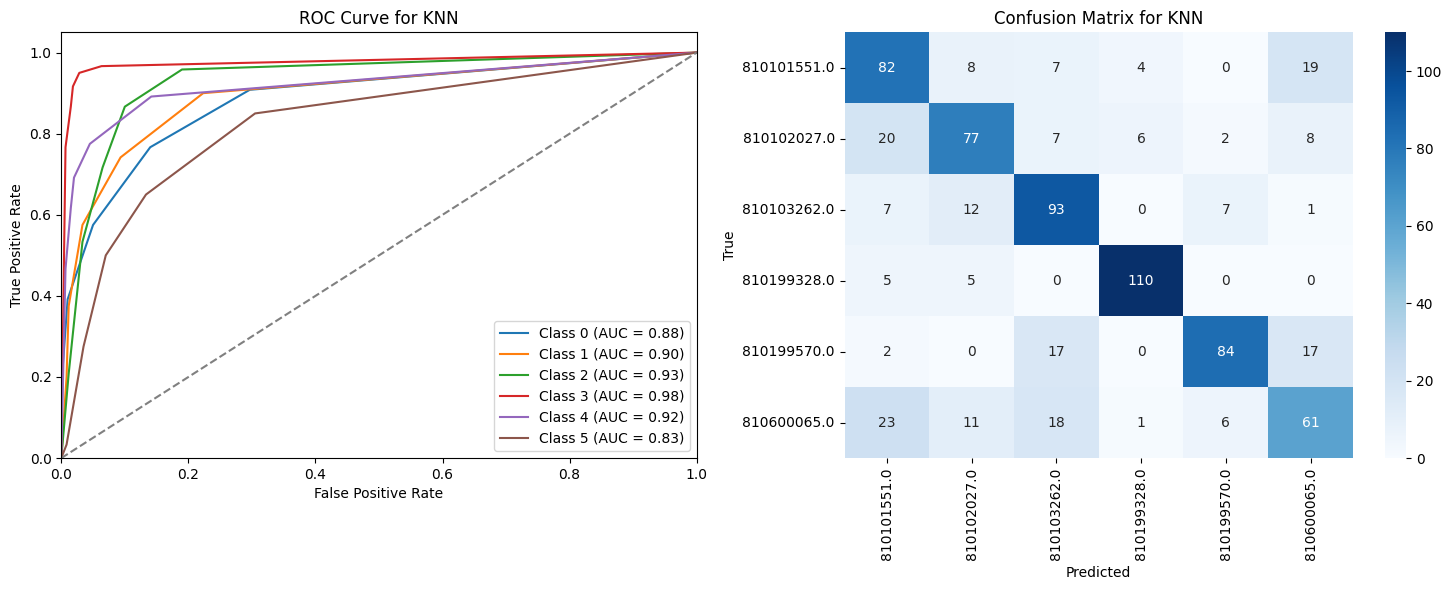

                  MLP                   
Accuracy: 0.7306
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 810101551.0       0.70      0.88      0.78       120
 810102027.0       0.88      0.82      0.85       120
 810103262.0       0.71      0.95      0.81       120
 810199328.0       0.96      0.97      0.96       120
 810199570.0       0.52      0.76      0.62       120
 810600065.0       0.00      0.00      0.00       120

    accuracy                           0.73       720
   macro avg       0.63      0.73      0.67       720
weighted avg       0.63      0.73      0.67       720



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


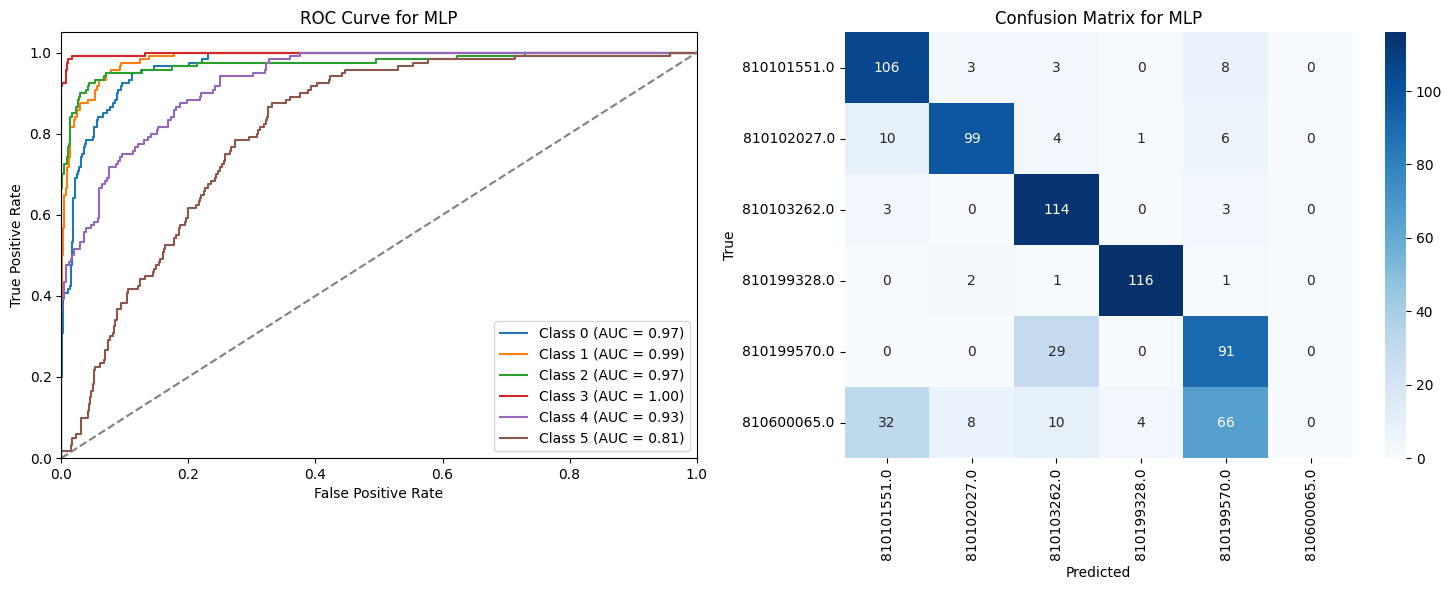

****************************************************************************************************
Round 3:
****************************************************************************************************
          Logistic Regression           
Accuracy: 0.6750
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 159403005.0       0.82      0.93      0.87       120
 810100135.0       0.62      0.45      0.52       120
 810101575.0       0.53      0.57      0.55       120
 810103241.0       0.87      0.75      0.81       120
 810199489.0       0.81      0.76      0.78       120
 810800024.0       0.47      0.59      0.52       120

    accuracy                           0.68       720
   macro avg       0.69      0.67      0.68       720
weighted avg       0.69      0.68      0.68       720



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


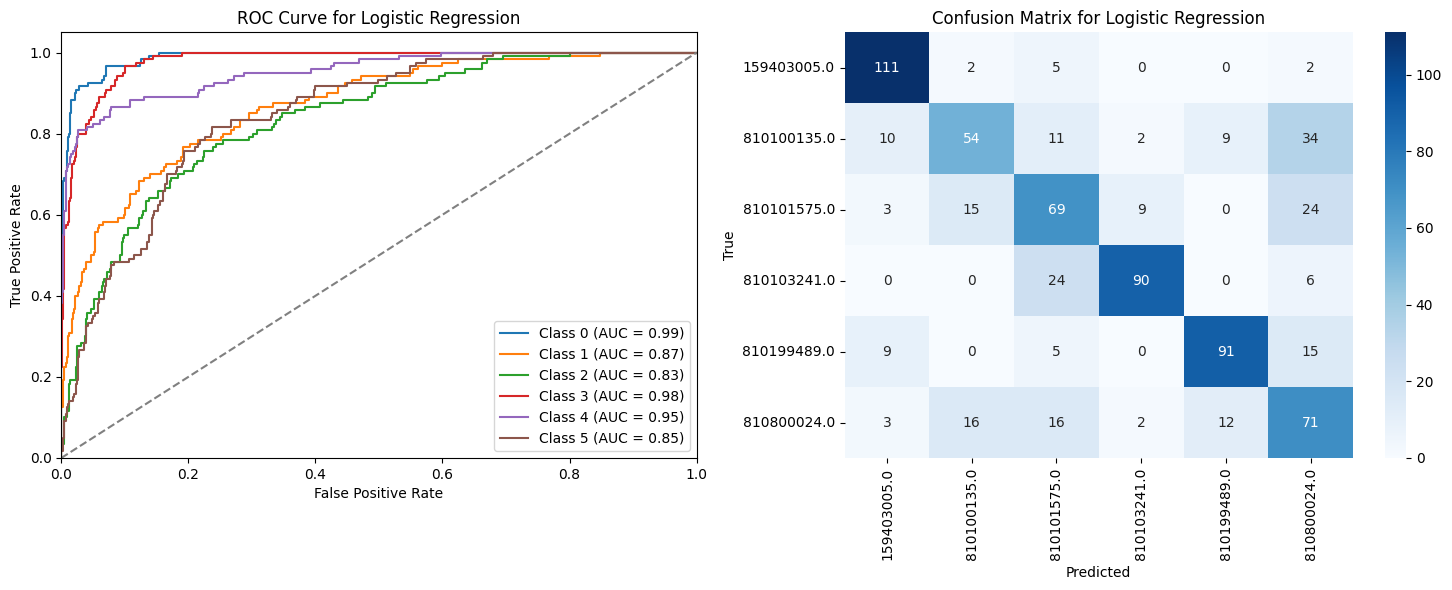

             Random Forest              
Accuracy: 0.9889
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 159403005.0       0.99      1.00      1.00       120
 810100135.0       0.99      1.00      1.00       120
 810101575.0       0.97      0.97      0.97       120
 810103241.0       0.98      0.97      0.97       120
 810199489.0       0.99      1.00      1.00       120
 810800024.0       1.00      0.99      1.00       120

    accuracy                           0.99       720
   macro avg       0.99      0.99      0.99       720
weighted avg       0.99      0.99      0.99       720



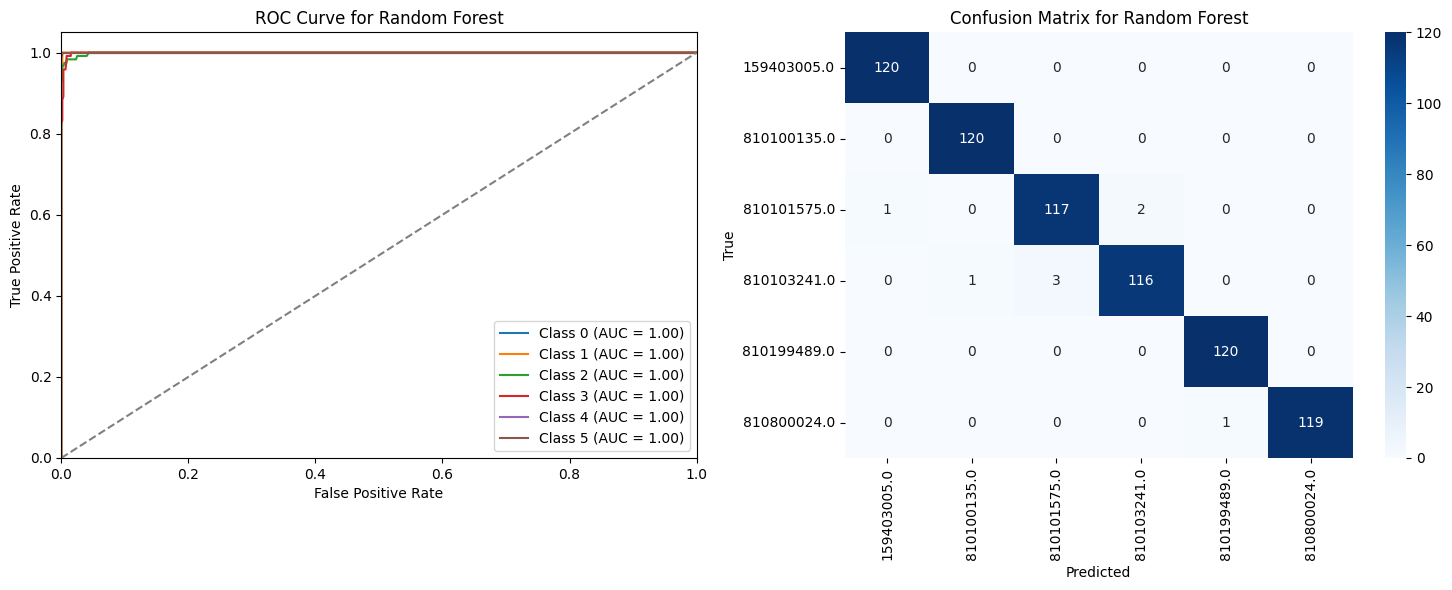

                  KNN                   
Accuracy: 0.6028
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 159403005.0       0.80      0.90      0.85       120
 810100135.0       0.39      0.53      0.45       120
 810101575.0       0.50      0.48      0.49       120
 810103241.0       0.81      0.73      0.77       120
 810199489.0       0.66      0.51      0.57       120
 810800024.0       0.52      0.47      0.49       120

    accuracy                           0.60       720
   macro avg       0.61      0.60      0.60       720
weighted avg       0.61      0.60      0.60       720



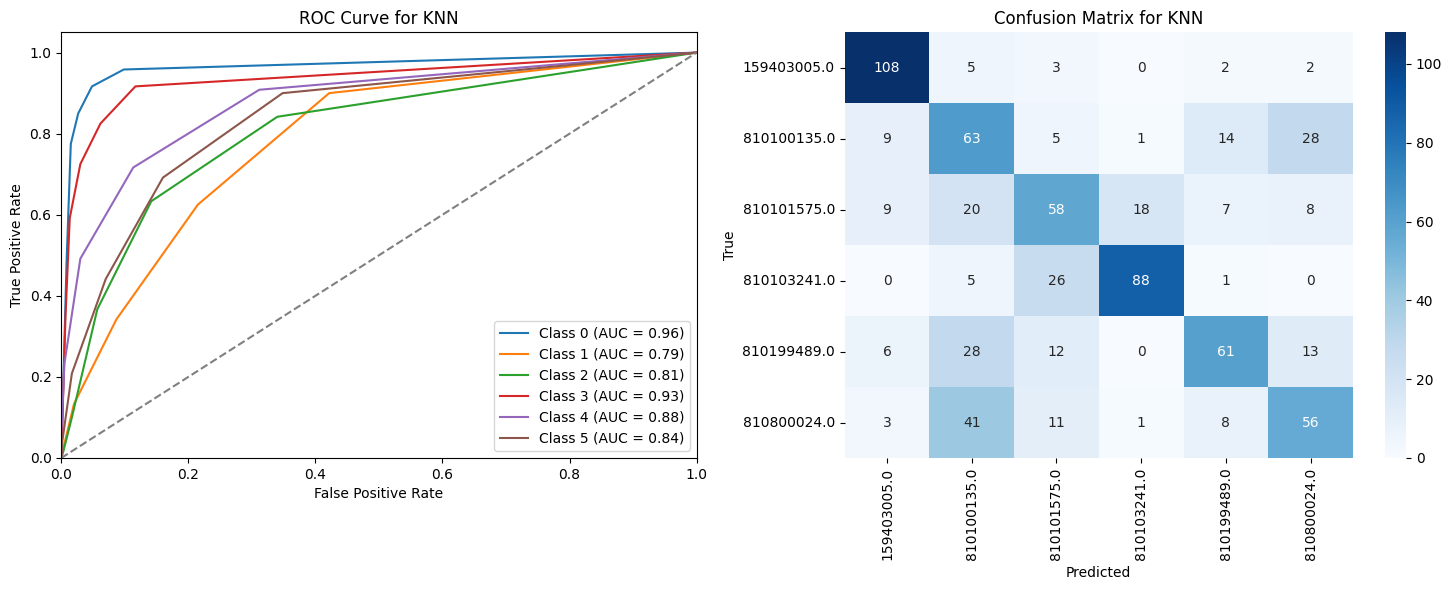

                  MLP                   
Accuracy: 0.8917
--------------------------------------------------
Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

 159403005.0       0.96      0.98      0.97       120
 810100135.0       0.89      0.92      0.90       120
 810101575.0       0.73      0.99      0.84       120
 810103241.0       0.99      0.74      0.85       120
 810199489.0       0.99      0.82      0.90       120
 810800024.0       0.89      0.89      0.89       120

    accuracy                           0.89       720
   macro avg       0.91      0.89      0.89       720
weighted avg       0.91      0.89      0.89       720



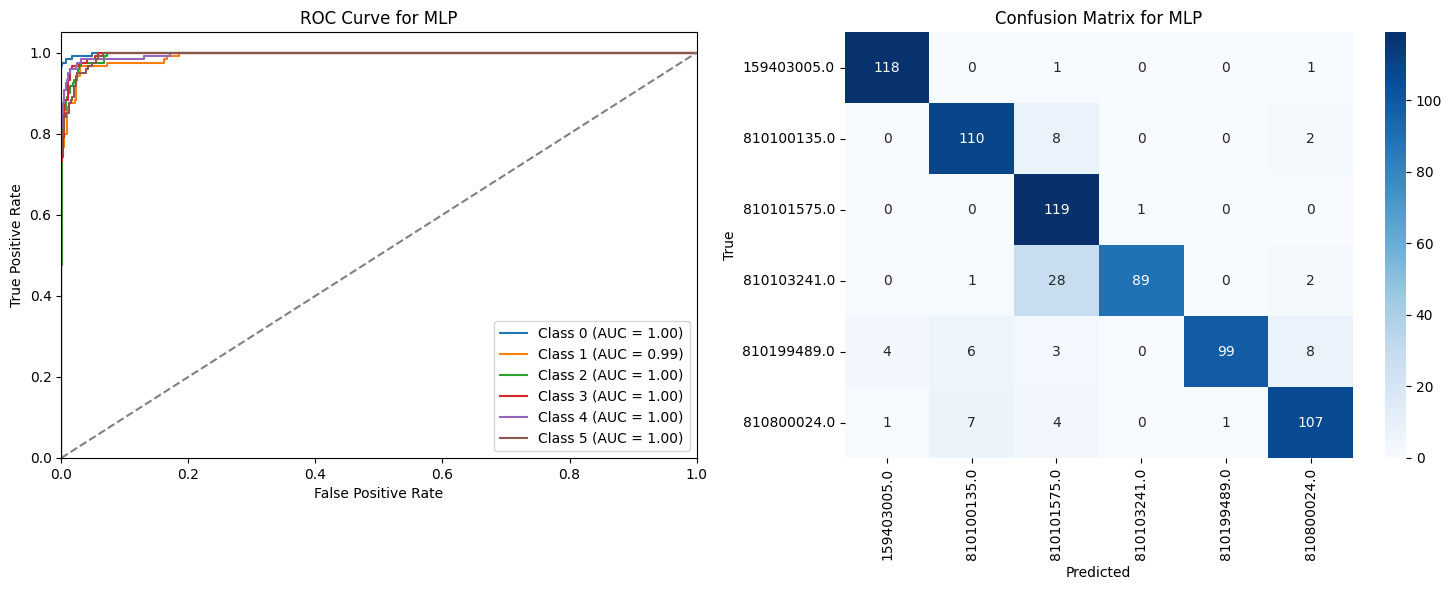

In [37]:
for round in range(NUM_ROUNDS):
    print("*"*100)
    print(f"Round {round+1}:")
    print("*"*100)

    # Define models
    models = {
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        # "SVM": SVC(kernel="linear"),
        "KNN": KNeighborsClassifier(n_neighbors=5),  # k=5 as default
        "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', max_iter=500, random_state=42)
    }

    for name, model in models.items():
        model.fit(X_trains[round], y_trains[round])  # Train the model
        y_pred = model.predict(X_tests[round])  # Make predictions

        # Print classification results
        print("="*50)
        print(f"{name:^40}")
        print("="*50)
        print(f"Accuracy: {accuracy_score(y_tests[round], y_pred):.4f}")
        print("-"*50)
        print("Classification Report:")
        print("-"*50)
        print(classification_report(y_tests[round], y_pred))
        print("="*50)

        # AI-Generated codes:

        # Binarize the output labels for multi-class ROC curve
        y_test_bin = label_binarize(y_tests[round], classes=np.unique(y_tests[round]))
        y_pred_prob = model.predict_proba(X_tests[round])

        # Create a figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot ROC Curve for each class on the first subplot
        for i in range(y_test_bin.shape[1]):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
            roc_auc = auc(fpr, tpr)
            ax1.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

        ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title(f'ROC Curve for {name}')
        ax1.legend(loc='lower right')

        # Plot Confusion Matrix on the second subplot
        cm = confusion_matrix(y_tests[round], y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_tests[round]), yticklabels=np.unique(y_tests[round]), ax=ax2)
        ax2.set_title(f'Confusion Matrix for {name}')
        ax2.set_xlabel('Predicted')
        ax2.set_ylabel('True')

        # Show the plots
        plt.tight_layout()
        plt.show()

#### Analysis

In this part, ChatGPT helped us extract some important but small features, and also we used it to edit our texts and make them more formal.

##### Round 1

**Analyzing Algorithms**

* **Logistic Regression** achieved an overall accuracy of 86.53%. The model shows balanced performance for most individuals: Individuals `810100222.0`, `810100268.0`, `810102032.0`, and `810103241.0` have high precision, recall, and F1-scores. This indicates that the model effectively identifies these individuals with minimal misclassifications. For individuals `810100590.0` and `810103093.0`, the precision and recall are lower (around 20%), resulting in F1-scores of 0.72. This suggests the model has some difficulty distinguishing these individuals from others. The slightly higher recall for certain individuals indicates the model may have increased false positives.

* **Random Forest** achieved the highest accuracy at 92.92%. It demonstrates strong precision, recall, and F1-scores across all individuals: Individual `810100268.0` achieved perfect precision and recall, leading to an F1-score of 1.00. Individuals `810102032.0` and `810103241.0` also have high scores, indicating excellent classification. Compared to Logistic Regression, individuals `810100590.0` and `810103093.0` show improved precision and recall (around 5-6%), resulting in higher F1-scores. Overall, F1-scores are the highest among all models, highlighting Random Forest's superior ability to classify each individual accurately.

* **KNN** achieved an accuracy of **77.92%**. The model shows variable performance across individuals: Individuals `810100268.0` and `810103241.0` have high precisionc recall and F1-score, indicating effective classification. For individuals `810100222.0`, `810100590.0`, and `810103093.0`, precision, recall and consequently F1-scores are lower (Lower Performance). The model tends to misclassify certain individuals, possibly confusing them with others, which results in a lower overall accuracy.

* **MLP** achieved an accuracy of 74.03%. The model exhibits inconsistent performance: Individual `810100268.0` has high precision but lower recall, resulting in an F1-score of 0.85. Similarly, individual `810103241.0` shows strong performance with an F1-score of 0.86. Individuals `810100590.0` and `810102032.0` have lower recall, leading to F1-scores between 0.61 and o.64. The model demonstrates challenges in consistently classifying all individuals, resulting in the lowest overall accuracy among the models.

**Comparing Algorithms**

* Among the four models, **Random Forest** performed the best with the highest accuracy (92.92%) and strong precision, recall, and F1-scores across all individuals. It effectively classifies each person in the dataset, making it the most effective model. **Logistic Regression** showed balanced performance with an accuracy of 86.53%. It classifies most individuals effectively but struggles with some, such as `810100590.0` and `810103093.0`. Both **KNN** and **MLP** demonstrated reasonable performance but exhibited significant variability across individuals and lower accuracies. KNN performed well for certain individuals but had difficulty with others, while MLP showed inconsistent classification abilities.

**Analyzing the ROC Curves**

* The most important thing these plots imply is that the rate of increaing in class 2 and 4 are less compared to other classes for almost other models. Some models hade sharp curves for other classes (like Logistic Regression and Random Forest), and in some of them, these curves are not as sharp as they should be. The conclusion is that the training data for class 2 and class 5 were not good.

* The other observations and interpretations from these plots is as same as what we did in the previous section for gender classification. So, in the following rounds, we just focus on analyzing the alagorithms and comparing them. As you can see, the result of analyzing ROC curves is as same as the conclusions we can understand from other things (like the classificatin report).

##### Round 2

**Analyzing Algorithms**

* **Logistic Regression** achieved an overall accuracy of 81.39%. The model shows variable performance across individuals: individuals `810101551.0`, `810102027.0`, `810103262.0`, and `810199570.0` have precision, recall, and moderate to high F1-scores, indicating the model effectively identifies these individual with some misclassifications. However, Individual `810199328.0` demonstrate the highest performance with an F1-score of 0.95. On the other hand, individual `810600065.0` shows lower precision, recall, and F1-score, suggesting the model struggles to correctly classify this individual, possibly due to overlapping features with other classes or insufficient distinctive patterns.

* **Random Forest** achieved the highest accuracy at 95.28%. It demonstrates strong precision, recall, and F1-scores across all individuals, for example, individual `810199328.0` achieved perfect precision and recall, leading to an F1-score of 1.00, indicating flawless classification. This highlights Random Forest's superior ability to accurately classify each individual. The model's ensemble approach likely captures complex patterns in the data, contributing to its high performance.

* **KNN** achieved an accuracy of 70.42%. The model shows variable performance across individuals: individual `810199328.0`'s metrics indicates effective classification. Individual `810199570.0`'s high precision and moderate recall showins reasonable performance but some misclassifications. However, for individual `810103262.0`, model captures many true instances but with false positives. In addition, for individuals `810101551.0`, `810102027.0`, and `810600065.0`, model struggles to accurately classify these individuals, possibly due to limitations in handling overlapping features or the choice of 'k' value affecting its sensitivity.

* **MLP** achieved an accuracy of **73.06%**. The model exhibits inconsistent performance: individual `810199328.0`'s metrics indicates excellent classification. For individuals `810101551.0`, `810102027.0`, and `810103262.0`, model effectively identifies but may have some false positives. However, for individual `810199570.0`, model has difficulty accurately predicting this individual, potentially due to overlapping features with other classes. Even worse, for Individual `810600065.0`, precision and recall are both 0.00, resulting in an F1-score of 0.00. This indicates the model fails to identify any instances of this individual correctly, which significantly affects overall performance. This could be due to factors like insufficient training data for this class, class imbalance, or suboptimal hyperparameter settings affecting the model's learning capacity.

**Comparing Algorithms**

* Among the four models, **Random Forest** performed the best with the highest accuracy and strong precision, recall, and F1-scores across all individuals. It effectively classifies each person in the dataset, making it the most effective model for this task. Its ability to handle complex feature interactions and reduce overfitting through ensemble techniques contributes to its superior performance. **Logistic Regression** showed reasonable performance. It classifies most individuals effectively but struggles with `810600065.0`, where it shows lower precision and recall. The model's simplicity allows for interpretability but may limit its ability to capture nonlinear patterns in the data, affecting its performance on individuals with less distinctive features. Both **KNN** and **MLP** demonstrated lower accuracies and significant variability across individuals.
  - **KNN** performed well for `810199328.0` but had difficulty with others, indicating sensitivity to the local structure of the data and potential issues with feature scaling or choice of distance metric.
  - **MLP** showed strong performance for some individuals but failed to classify `810600065.0` entirely, suggesting issues with network architecture, insufficient training epochs, or the need for better hyperparameter tuning.

##### Round 3

**Analyzing Algorithms**

* **Logistic Regression** achieved an overall accuracy of **67.50%**. The model shows variable performance across individuals: individual `159403005.0` has high precision, recall, and F1-score, indicating effective classification. Individual `810103241.0` also performs well, with a F1-score of 0.81. However, individuals `810100135.0`, `810101575.0`, and `810800024.0` have lower precision and recall, resulting in low F1-scores. This suggests the model struggles to accurately classify these individuals, possibly due to overlapping features or insufficient distinctive patterns in their data.

* **Random Forest** achieved the highest accuracy at **98.89%**. It demonstrates exceptional precision, recall, and F1-scores across all individuals. For example, individuals `159403005.0`, `810100135.0`, and `810199489.0` achieved near-perfect precision and recall, leading to F1-scores of 1.00 for most cases. The Random Forest model's superior ability to accurately classify each individual is evident, making it highly effective.

* **KNN** achieved an accuracy of **60.28%**. The model shows variable performance across individuals. Individual `159403005.0` has a good F1-score, indicating effective classification. Individual `810103241.0` also shows reasonable performance. However, individuals `810100135.0`, `810101575.0`, `810199489.0`, and `810800024.0` have lower precision and recall, resulting in F1-scores around 0.45 to 0.57. The model struggles to classify these individuals accurately, possibly due to sensitivity to feature scaling or insufficient differentiation in their data. The KNN model's performance varies significantly across individuals, leading to the lowest overall accuracy among the models.

* **MLP** achieved an overall accuracy of **89.17%**. The model shows strong performance for most individuals. Individual `159403005.0` has high precision, recall, and F1-score. Individuals `810100135.0`, `810199489.0`, and `810800024.0` also have high precision and recall, resulting in F1-scores ranging from 0.89 to 0.97. But, individual `810101575.0` shows high recall but slightly lower precision. On the other hand, individual `810103241.0` has excellent precision but lower recall. Overall, the MLP model effectively classifies most individuals but has some difficulty with recall for certain individuals, suggesting potential overfitting or the need for further hyperparameter tuning.

**Comparing Algorithms**

* Among the four models, **Random Forest** performed the best with the highest accuracy (98.89%) and exceptional precision, recall, and F1-scores across all individuals, effectively classifying each person in the dataset. **MLP** also showed strong performance with an accuracy of 89.17%, classifying most individuals effectively but with slight variability in recall for some individuals. **Logistic Regression** showed moderate performance, performing well for some individuals but struggling with others, indicating limitations in capturing complex patterns in the data. **KNN** demonstrated the lowest accuracy (**60.28%**) and variable performance across individuals, suggesting challenges in consistently distinguishing between individuals, possibly due to sensitivity to data characteristics or parameter settings.

# Part 3: Clustering

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3D Plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# Machine Learning & Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

# Metrics for Evaluation
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    homogeneity_score,
    confusion_matrix
)

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Optimization & Utilities
from kneed import KneeLocator
from collections import defaultdict
from math import log2, sqrt
from random import randint

from scipy.spatial.distance import cdist

## Combine Data

As we want to perform clustering and do not need a test or validation split, we combine all data to increase the training set. We also drop unnecessary columns like "Student ID" and "Frame ID" since they do not contribute to clustering:

In [ ]:
df_clustring = pd.concat([test_df, train_df], ignore_index=True)
# df_clustring = train_df
features = df_clustring.drop(columns=["Student ID", "Frame ID"], errors="ignore")
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475 entries, 0 to 474
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              475 non-null    int64  
 1   Duration            475 non-null    float64
 2   Sampling Rate       475 non-null    float64
 3   Mean Amp            475 non-null    float64
 4   Max Amp             475 non-null    float64
 5   Min Amp             475 non-null    float64
 6   Spectral Centroid   475 non-null    float64
 7   Spectral Bandwidth  475 non-null    float64
 8   Zero Crossing Rate  475 non-null    float64
 9   Energy              475 non-null    float64
 10  Log Mel Spec        475 non-null    float64
 11  MFCC-1              475 non-null    float64
 12  MFCC-2              475 non-null    float64
 13  MFCC-3              475 non-null    float64
 14  MFCC-4              475 non-null    float64
 15  MFCC-5              475 non-null    float64
 16  MFCC-6  

## Method 1: KMeans


Now, we want to determine the optimal number of clusters (k) for KMeans clustering. We test different values of k (from 2 to 14) and evaluate them using the Elbow Method (SSE) and Silhouette Score. Finally, we calculate the best k from both methods and take their average for a balanced choice.

In [ ]:
range_n_clusters = list(range(2, 15))
sse = []
silhouette_scores = []


for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state = 42)
    cluster_labels = kmeans.fit_predict(features)
    #Elbow Method
    sse.append(kmeans.inertia_)

    #Silhouette score:
    silhouette_scores.append(silhouette_score(features, cluster_labels))


In [ ]:
knee = np.diff(sse, 2)
optimal_k_elbow = np.argmin(knee) + 2
optimal_k_silhouette = range_n_clusters[np.argmax(silhouette_scores)]

avg_k = int((optimal_k_elbow + optimal_k_silhouette )/ 2)

print(f"Optimal k for Elbow Method: {optimal_k_elbow}")
print(f"Optimal k for Silhouette Score: {optimal_k_silhouette}")
print(f"Avg. of Optimal K(s): {avg_k}")

Optimal k for Elbow Method: 3
Optimal k for Silhouette Score: 2
Avg. of Optimal K(s): 2


Here, we plot the Elbow Method and Silhouette Score to visually determine the optimal number of clusters. The first plot shows how SSE decreases with more clusters, with dashed lines marking the Elbow point and average k. The second plot displays Silhouette Scores, where the highest score indicates the best cluster separation, also highlighting the optimal choices.

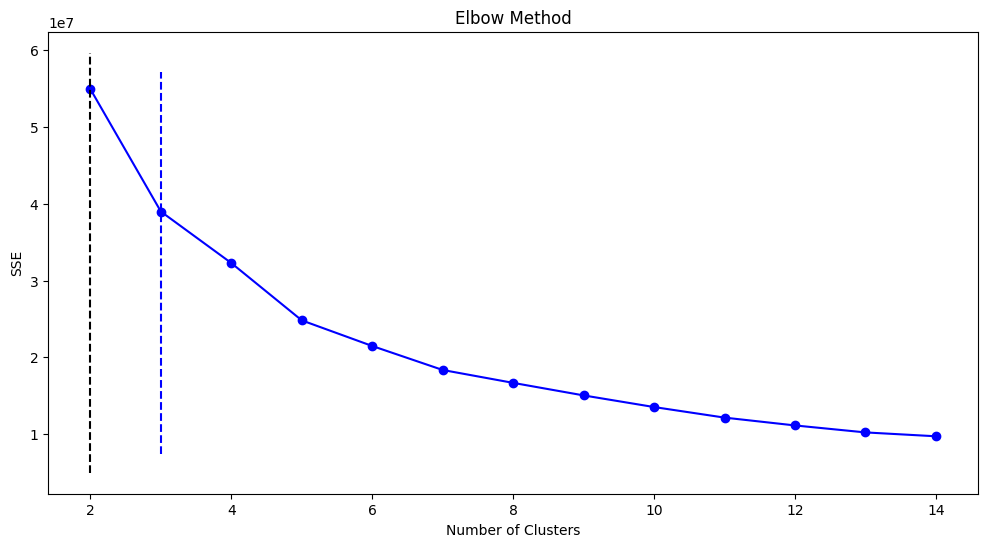

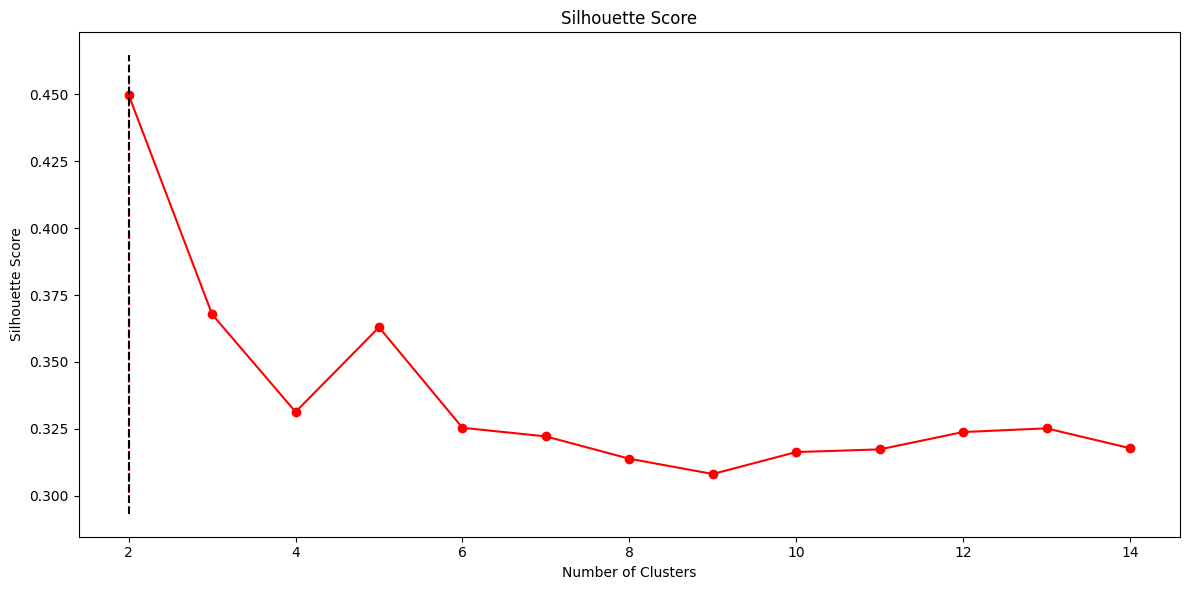

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(range_n_clusters, sse, marker='o', color='blue')
plt.vlines(optimal_k_elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='blue')
plt.vlines(avg_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color = 'black')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')


plt.figure(figsize=(12, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', color='red')
plt.vlines(optimal_k_silhouette, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color='red')
plt.vlines(avg_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', color = 'black')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')


plt.tight_layout()
plt.show()

Here, we **initialize and train a KMeans model** using the optimal number of clusters (**k**) determined by the **Silhouette Score**.   
We use **Silhouette Score** because the **Elbow Method relies on inertia**, which may not be the best metric for **high-dimensional data**.  
The **Silhouette Score** provides a better measure of **how well-separated** the clusters are, making it a more reliable choice.

In [ ]:
kmeans = KMeans(n_clusters= optimal_k_silhouette , random_state = 42)
kmeans.fit(features)

KMeans(n_clusters=2, random_state=42)

In [ ]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

## Method 2: DBSCAN

Here, we find the best eps and min_samples (n_neighbors) for DBSCAN using the Elbow Method on k-nearest neighbor distances.   
Since DBSCAN relies on density, we analyze different values of n_neighbors to estimate the optimal eps.   
The Silhouette Score is used to evaluate clustering quality, and we select the parameters that produce the best score. This ensures we choose an eps value that balances density-based clustering while avoiding excessive noise.

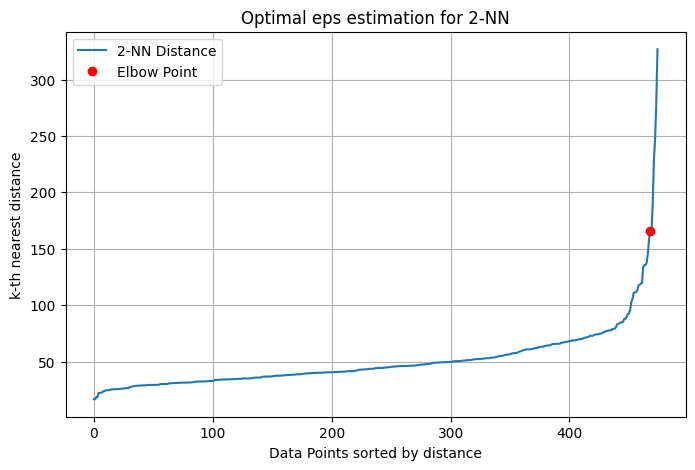

n_neighbors: 2, Estimated eps: 165.8011
Silhouette Score for n_neighbors=2, eps=165.8011: 0.3885


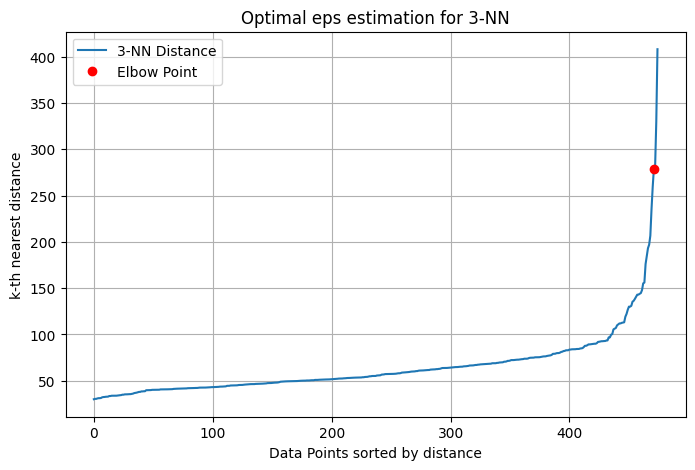

n_neighbors: 3, Estimated eps: 279.1942
Silhouette Score for n_neighbors=3, eps=279.1942: 0.4361


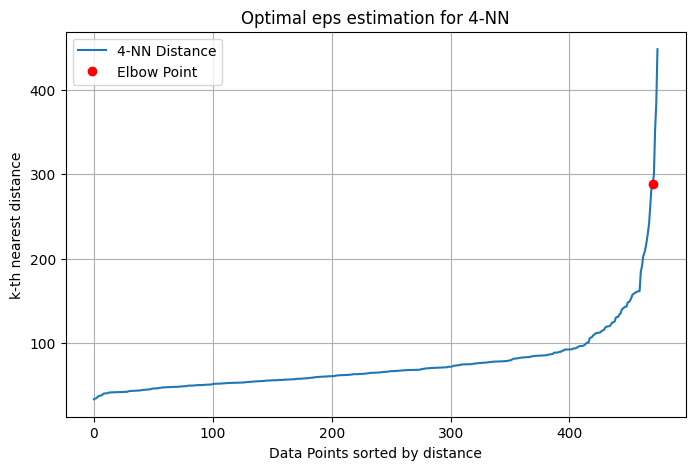

n_neighbors: 4, Estimated eps: 288.9779
Silhouette Score for n_neighbors=4, eps=288.9779: 0.4361


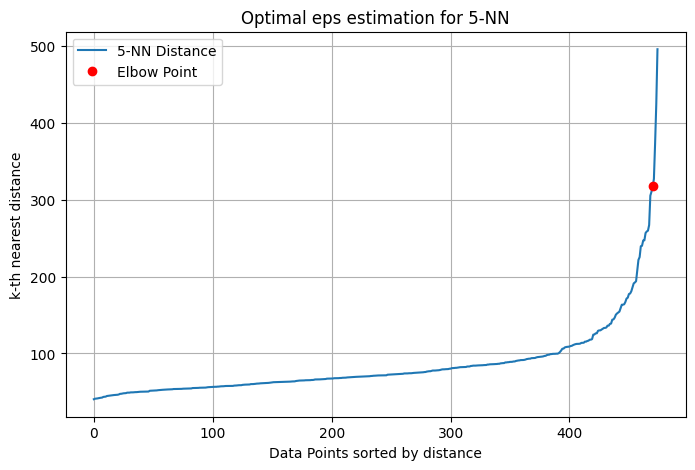

n_neighbors: 5, Estimated eps: 316.9843
Silhouette Score for n_neighbors=5, eps=316.9843: 0.4361


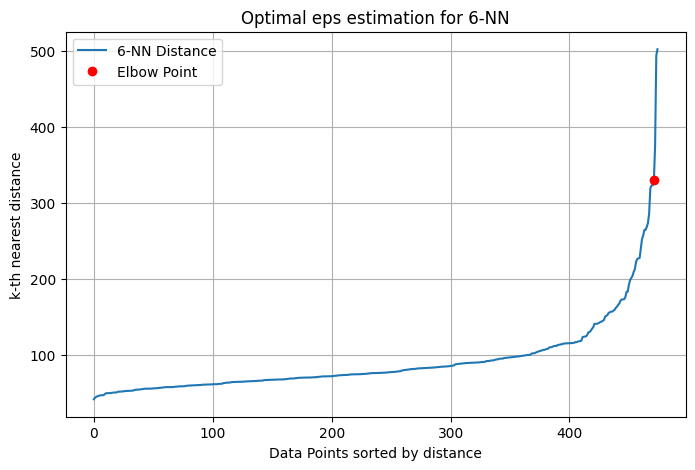

n_neighbors: 6, Estimated eps: 330.4627


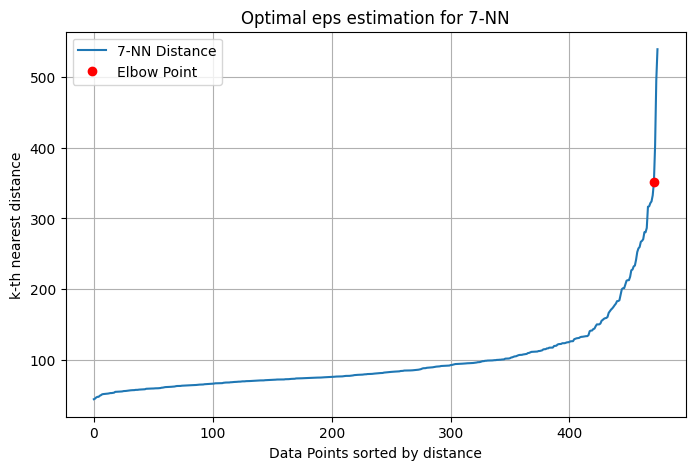

n_neighbors: 7, Estimated eps: 350.9351


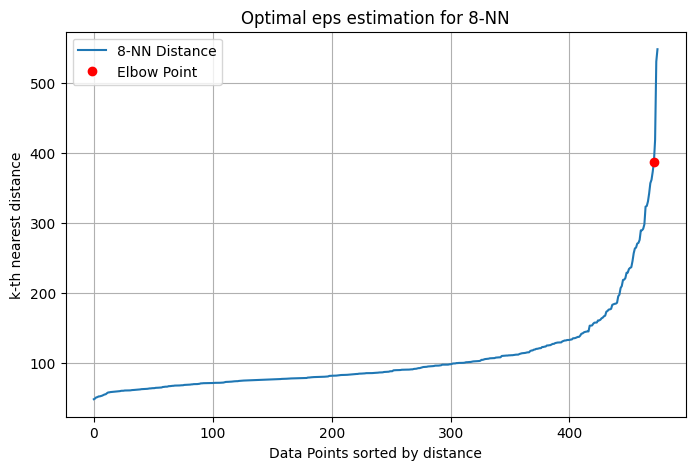

n_neighbors: 8, Estimated eps: 386.7887


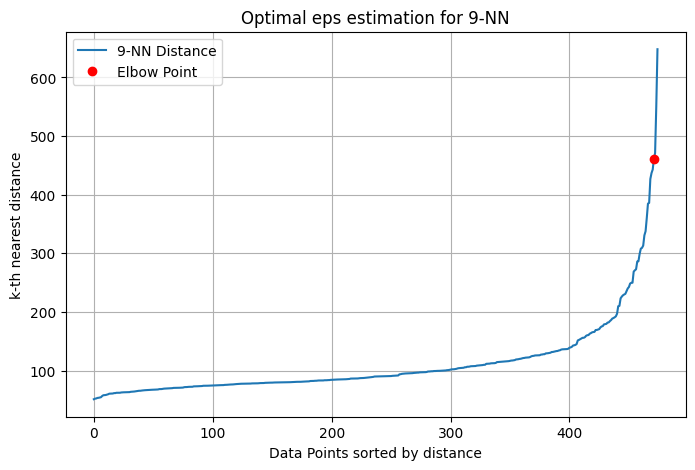

n_neighbors: 9, Estimated eps: 461.3128


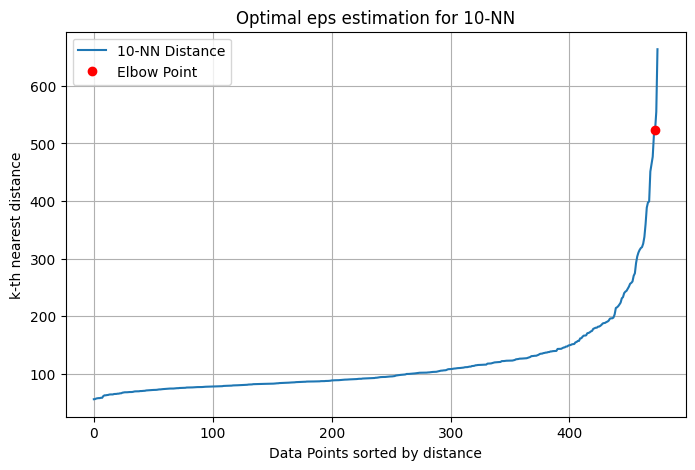

n_neighbors: 10, Estimated eps: 523.4703


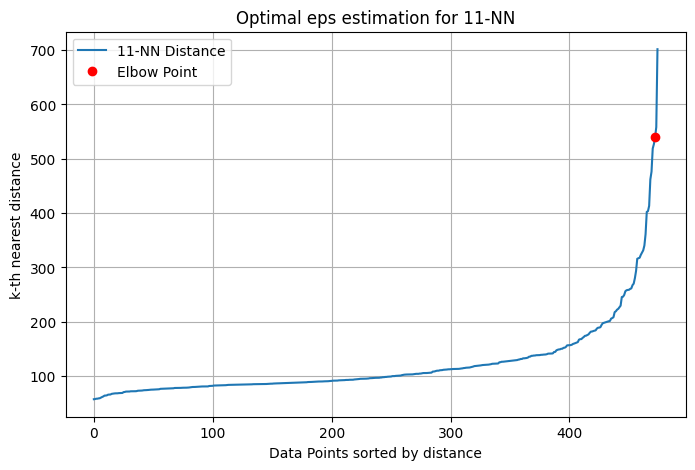

n_neighbors: 11, Estimated eps: 539.9486

Best Parameters:
n_neighbors: 3, eps: 279.1942, Best Silhouette Score: 0.4361


In [ ]:
def find_best_eps_nneighbors(features, n_neighbors_list):
    best_score = -1
    best_eps = None
    best_n_neighbors = None
    results = []

    for n_neighbors in n_neighbors_list:
        # Step 1: Compute nearest neighbor distances
        nearest_neighbors = NearestNeighbors(n_neighbors=n_neighbors)
        nearest_neighbors.fit(features)
        distances, indices = nearest_neighbors.kneighbors(features)

        # Step 2: Sort distances for elbow method
        sorted_distances = np.sort(distances[:, n_neighbors - 1], axis=0)

        # Step 3: Find the elbow point
        differences = np.diff(sorted_distances, 2)
        optimal_index = np.argmax(differences)
        optimal_eps = sorted_distances[optimal_index]

        # Plot k-distance graph
        plt.figure(figsize=(8, 5))
        plt.plot(sorted_distances, label=f'{n_neighbors}-NN Distance')
        plt.plot(optimal_index, optimal_eps, 'ro', label='Elbow Point')
        plt.xlabel('Data Points sorted by distance')
        plt.ylabel('k-th nearest distance')
        plt.title(f'Optimal eps estimation for {n_neighbors}-NN')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"n_neighbors: {n_neighbors}, Estimated eps: {optimal_eps:.4f}")

        # Step 4: Run DBSCAN with estimated eps
        dbscan = DBSCAN(eps=optimal_eps, min_samples=n_neighbors)
        cluster_labels = dbscan.fit_predict(features)

        # Ignore clusters with only noise (-1 labels)
        if len(set(cluster_labels)) > 1:
            score = silhouette_score(features, cluster_labels)
            results.append((n_neighbors, optimal_eps, score))

            print(f"Silhouette Score for n_neighbors={n_neighbors}, eps={optimal_eps:.4f}: {score:.4f}")

            # Step 5: Update best parameters if score is improved
            if score > best_score:
                best_score = score
                best_eps = optimal_eps
                best_n_neighbors = n_neighbors

    print("\nBest Parameters:")
    print(f"n_neighbors: {best_n_neighbors}, eps: {best_eps:.4f}, Best Silhouette Score: {best_score:.4f}")

    return best_n_neighbors, best_eps, results

n_neighbors_list = range(2, 12)  # Test different values

best_n, best_eps, results = find_best_eps_nneighbors(features, n_neighbors_list)


In [ ]:
dbscan = DBSCAN(eps=best_eps, min_samples = best_n)
dbscan.fit(features)

DBSCAN(eps=279.1941865035346, min_samples=3)

In [ ]:
dbscan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [ ]:
len(list(set(dbscan.labels_)))

2

## Visualization: PCA

Here, we use **PCA** to reduce the data to 2D or 3D so we can visualize the clusters. We then plot the transformed data with colors representing different cluster labels.

In [ ]:
def plot_PCD_2(features, labels, title):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    num_clusters = len(np.unique(labels))
    colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))
    cmap = ListedColormap(colors)

    plt.figure(figsize=(10,5))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap=cmap, edgecolor='k', s=50)
    plt.title(f'PCA for {title}')
    plt.colorbar(scatter, ticks=np.arange(num_clusters), label='Cluster Label')
    plt.grid(True)
    plt.show()

In [ ]:
def plot_PCD_3(features, labels, title):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    num_clusters = len(np.unique(labels))
    colors = plt.cm.tab20(np.linspace(0, 1, num_clusters))
    cmap = ListedColormap(colors)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels, cmap=cmap, edgecolor='k', s=50)
    plt.title(f'PCA for {title}')
    plt.colorbar(scatter, ticks=np.arange(num_clusters), label='Cluster Label')
    plt.show()


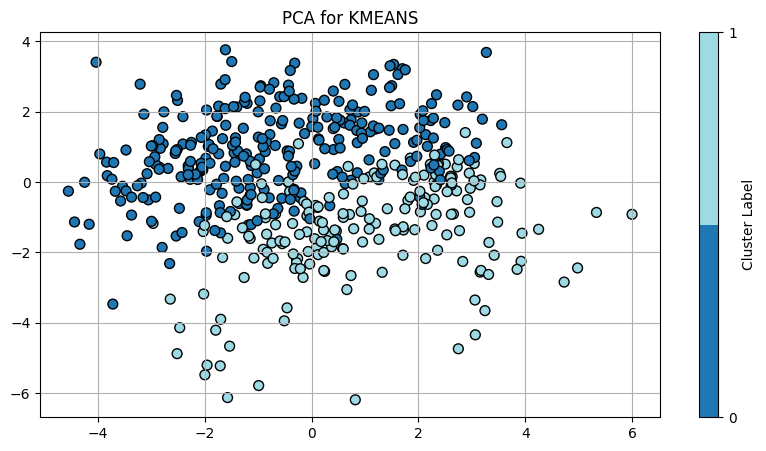

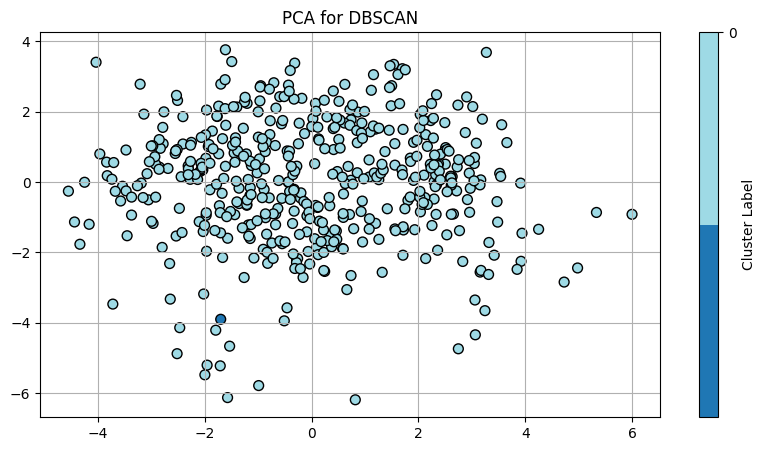

In [ ]:
plot_PCD_2(features, kmeans.labels_, "KMEANS")
plot_PCD_2(features, dbscan.labels_, "DBSCAN")

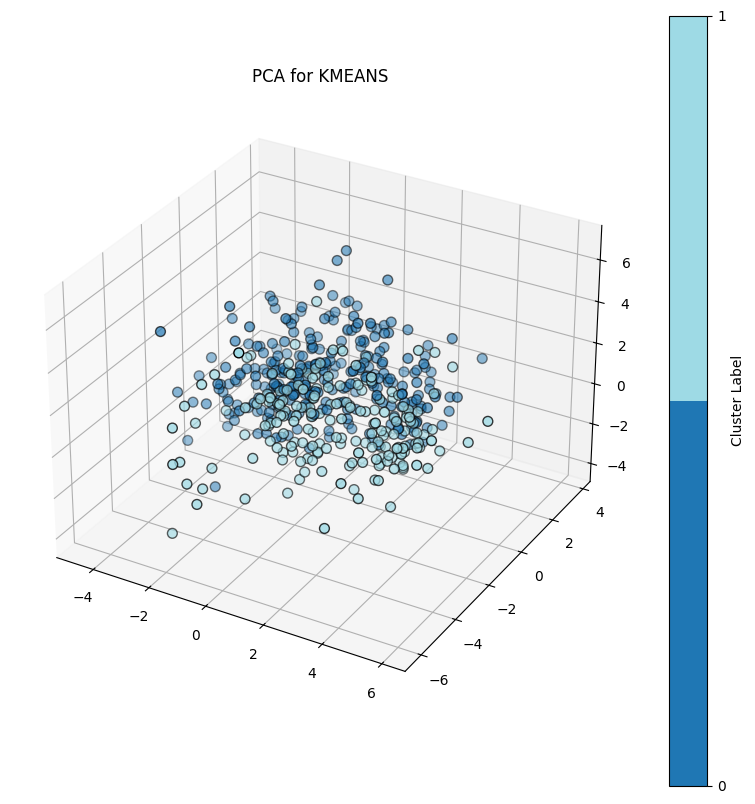

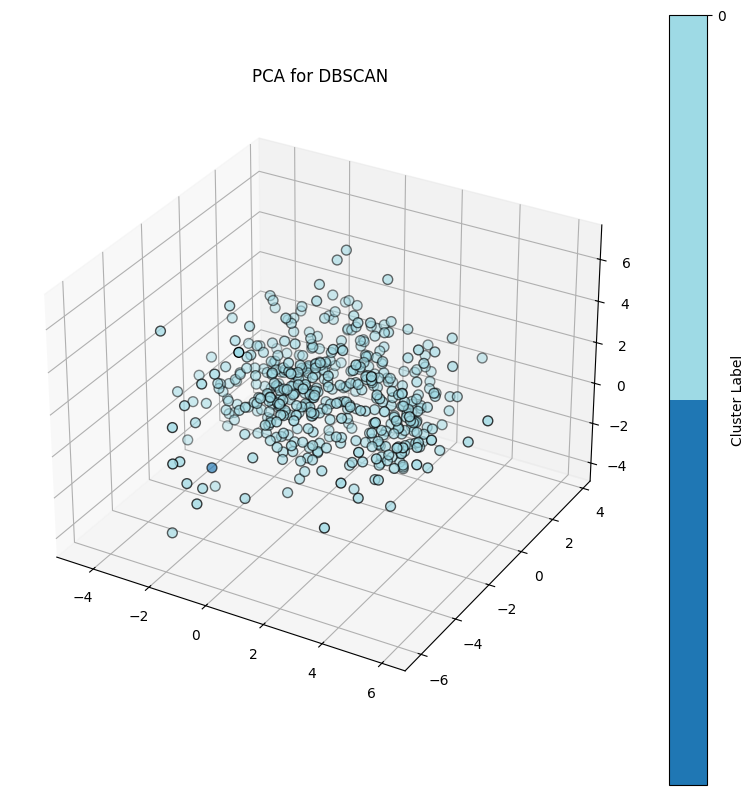

In [ ]:
plot_PCD_3(features, kmeans.labels_, "KMEANS")
plot_PCD_3(features, dbscan.labels_, "DBSCAN")

## Evaluation

This function evaluates **K-Means** and **DBSCAN** clustering using **Silhouette Score, Davies-Bouldin Score,** and **Calinski-Harabasz Score** to measure cluster quality. It prints the evaluation results, ensuring DBSCAN is only assessed if it forms more than one cluster. Finally, it returns a dictionary containing the scores for both clustering methods.

In [ ]:
def evaluate_clustering(features, kmeans, dbscan):
    # K-Means Evaluation
    kmeans_labels = kmeans.labels_
    ss_kmeans = silhouette_score(features, kmeans_labels)
    db_score_kmeans = davies_bouldin_score(features, kmeans_labels)
    ch_score_kmeans = calinski_harabasz_score(features, kmeans_labels)

    print("=== KMEANS Clustering Evaluation ===")
    print(f"Silhouette Score: {ss_kmeans:.3f} (Higher is better)")
    print(f"Davies-Bouldin Score: {db_score_kmeans:.3f} (Lower is better)")
    print(f"Calinski-Harabasz Score: {ch_score_kmeans:.3f} (Higher is better)")
    print("____" * 20)

    # DBSCAN Evaluation
    dbscan_labels = dbscan.labels_

    if len(set(dbscan_labels)) > 1:
        ss_dbscan = silhouette_score(features, dbscan_labels)
        db_score_dbscan = davies_bouldin_score(features, dbscan_labels)
        ch_score_dbscan = calinski_harabasz_score(features, dbscan_labels)

        print("=== DBSCAN Clustering Evaluation ===")
        print(f"Silhouette Score: {ss_dbscan:.3f} (Higher is better)")
        print(f"Davies-Bouldin Score: {db_score_dbscan:.3f} (Lower is better)")
        print(f"Calinski-Harabasz Score: {ch_score_dbscan:.3f} (Higher is better)")
        print("____" * 20)
    else:
        ss_dbscan, db_score_dbscan, ch_score_dbscan = None, None, None
        print("DBSCAN produced only noise, skipping evaluation.")

    return {
        "KMeans": {"Silhouette": ss_kmeans, "Davies-Bouldin": db_score_kmeans, "Calinski-Harabasz": ch_score_kmeans},
        "DBSCAN": {"Silhouette": ss_dbscan, "Davies-Bouldin": db_score_dbscan, "Calinski-Harabasz": ch_score_dbscan}
    }

results = evaluate_clustering(features, kmeans, dbscan)


=== KMEANS Clustering Evaluation ===
Silhouette Score: 0.450 (Higher is better)
Davies-Bouldin Score: 0.826 (Lower is better)
Calinski-Harabasz Score: 526.085 (Higher is better)
________________________________________________________________________________
=== DBSCAN Clustering Evaluation ===
Silhouette Score: 0.436 (Higher is better)
Davies-Bouldin Score: 0.420 (Lower is better)
Calinski-Harabasz Score: 4.256 (Higher is better)
________________________________________________________________________________


This code calculates intra-cluster distances (compactness) and inter-cluster distances (separation) for K-Means and DBSCAN using pairwise distances. Lower intra-cluster distances indicate tighter clusters, while higher inter-cluster distances suggest well-separated clusters. The results help assess which algorithm forms more compact and distinct clusters.

In [ ]:
def compute_intracluster_distances(features, labels):
    clusters = {i: features[labels == i] for i in np.unique(labels)}
    intra_distances = {i: np.mean(cdist(clusters[i], clusters[i])) for i in clusters}
    return intra_distances

kmeans_intra_dist = compute_intracluster_distances(features, kmeans.labels_)
dbscan_intra_dist = compute_intracluster_distances(features, dbscan.labels_)

print("\nKMeans Intra-cluster Distances (Lower is better):", kmeans_intra_dist)
print("DBSCAN Intra-cluster Distances (Lower is better):", dbscan_intra_dist)

def compute_intercluster_distances(features, labels):
    clusters = {i: features[labels == i] for i in np.unique(labels)}
    inter_distances = {f"{i}-{j}": np.mean(cdist(clusters[i], clusters[j])) for i in clusters for j in clusters if i != j}
    return inter_distances

kmeans_inter_dist = compute_intercluster_distances(features, kmeans.labels_)
dbscan_inter_dist = compute_intercluster_distances(features, dbscan.labels_)

print("\nKMeans Inter-cluster Distances (Higher is better):", kmeans_inter_dist)
print("DBSCAN Inter-cluster Distances (Higher is better):", dbscan_inter_dist)




KMeans Intra-cluster Distances (Lower is better): {0: 378.8756327393683, 1: 472.41400685214677}
DBSCAN Intra-cluster Distances (Lower is better): {-1: 0.0, 0: 596.0768169629658}

KMeans Inter-cluster Distances (Higher is better): {'0-1': 803.5949460898474, '1-0': 803.5949460898474}
DBSCAN Inter-cluster Distances (Higher is better): {'-1-0': 1106.5210987591965, '0--1': 1106.5210987591965}


### Analysis


**How Similar Are Points Within Each Cluste?** (lower is better)
- **KMeans:** Forms tighter,more compact clusters (378.88 and 472.41).
- **DBSCAN:** Clusters are more spread out (**596.08**), meaning points inside are more dispersed.

**How Well Are Clusters Separated?** (Higher is better)
- **KMeans:** Has decent separation (**803.59**).
- **DBSCAN:** Does a better job at keeping outliers separate (**1106.52**).

**Cluster Quality**
| Metric  | KMeans  | DBSCAN  | Best |
|---------|--------|--------|------|
| **Silhouette Score** (Higher = better structure) | 0.450 | 0.436 | **KMeans** |
| **Davies-Bouldin Score** (Lower = better separation) | 0.826 | 0.420 | **DBSCAN** |
| **Calinski-Harabasz Score** (Higher = better compactness) | 526.085 | 4.256 | **KMeans** |

**How Do Clusters Get Assigned?**
- **KMeans:** Puts points in clusters based on proximity to a center (good for evenly shaped groups).
- **DBSCAN:** Groups points based on density—anything that doesn’t fit gets labeled as an outlier (-1).

**Which Clustering Works Best?**
- if we want compact, well-separated clusters: KMeans
- if we need to handle noise or irregularly shaped clusters: DBSCAN.